In [1]:
import psycopg2
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

In [2]:
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres",
    password="postgres"
)

cur = conn.cursor()

cur.execute("SELECT version();")
print(cur.fetchone())

('PostgreSQL 15.2, compiled by Visual C++ build 1914, 64-bit',)


In [3]:
# Connect to db
conn = psycopg2.connect(host='localhost', dbname='mimic', user='postgres', password='postgres', options='-c search_path=mimiciii')
#conn = psycopg2.connect(dbname='mimic', user='postgres')
cur = conn.cursor() 

# Read in table with patients & admissions (inner join on subject_id) and icu_stays (inner joinon subject_id and hadm_id)
icustay_details = pd.read_sql_query("SELECT * FROM mimiciii.flicu_icustay_detail;", conn)

# Read in vital and lab signs
pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
pivoted_lab = pd.read_sql_query("SELECT * FROM mimiciii.ckd_pivoted_lab;", conn)

# Read in lab measurements
# Use flicu_pivoted_lab (as it only takes the lab tests during ICU stay)
#query = "SELECT * FROM mimiciii.flicu_pivoted_lab;"
# Alternative:  Use the lab values recorded previous to the ICU stay (although during same hospital admission!), 
# then sample them  (8h intervalls) and then forward fill plus cap at either icu admission time of first vital sign recorded
#query = "SELECT * FROM mimiciii.pivoted_lab;"
#pivoted_lab = pd.read_sql_query(query, conn)

# Close the cursor and connection to so the server can allocate bandwidth to other requests
cur.close()
conn.close()

C:\Users\navim\AppData\Local\Temp\ipykernel_25608\16251075.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  icustay_details = pd.read_sql_query("SELECT * FROM mimiciii.flicu_icustay_detail;", conn)
C:\Users\navim\AppData\Local\Temp\ipykernel_25608\16251075.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
C:\Users\navim\AppData\Local\Temp\ipykernel_25608\16251075.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pivoted_lab = pd.read_s

In [4]:
pivoted_vital['pedaledema'].unique()

array([nan,  3.,  2.])

In [5]:
pivoted_vital.shape

(9207039, 15)

In [6]:
pivoted_vital.columns

Index(['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity',
       'pedaledema', 'appetite_median', 'ckd'],
      dtype='object')

In [7]:
pivoted_lab.columns

Index(['icustay_id', 'subject_id', 'charttime', 'aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria', 'ckd'],
      dtype='object')

In [8]:
icustay_details.describe()

,subject_id,hadm_id,icustay_id,los_hospital,admission_age,hospital_expire_flag,hospstay_seq,los_icu,icustay_seq,label_death_icu,label_cor_art,diabetes_mellitus,ckd,anemia_flag
count,61051.000000,61051.000000,61051.000000,61051.000000,61051.000000,61051.000000,61051.000000,61041.000000,61051.000000,61051.000000,61051.000000,61051.000000,61051.000000,61051.000000
mean,33961.698989,149946.928945,249968.598696,11.320283,64.856674,0.107975,1.418568,4.931644,1.070908,0.073774,0.212838,0.170693,0.082849,0.125682
std,28153.637888,28899.070114,28891.923533,14.301661,56.970061,0.310352,1.510997,9.664428,0.301838,0.261406,0.409318,0.376244,0.275656,0.331493
min,2.000000,100001.000000,200001.000000,-0.945139,0.000007,0.000000,1.000000,0.000139,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12085.500000,124949.000000,224951.000000,3.910069,44.281191,0.000000,1.000000,1.109491,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24352.000000,149883.000000,249949.000000,6.945833,62.054949,0.000000,1.000000,2.094815,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,54366.000000,174997.500000,274974.500000,13.059722,76.068514,0.000000,1.000000,4.502199,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99999.000000,199999.000000,299999.000000,294.660417,311.561027,1.000000,41.000000,173.072512,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Setting window length 

In [9]:
WINDOW_LENGTH = 24*4

### Keeping records that are atleast window length

In [10]:
data= icustay_details.copy()
data = data[data.los_icu >= WINDOW_LENGTH/24.0]

In [11]:
filtered_icustay_ids = pd.DataFrame(data['icustay_id'].unique(), columns=['icustay_id'])

In [12]:
# Drop measurements with no belonging icustay_id
pivoted_vital = pivoted_vital.dropna(subset=['icustay_id'])
pivoted_lab = pivoted_lab.dropna(subset=['icustay_id'])

#check the shape 
print(pivoted_vital.shape)

# Cast icustay_id types to int
pivoted_vital['icustay_id'] = pivoted_vital['icustay_id'].astype(int)
pivoted_lab['icustay_id'] = pivoted_lab['icustay_id'].astype(int)

print(len(pivoted_vital['icustay_id'].unique()))

# Keep only values of patients in previously filtered icustay_ids in labs and vitals
pivoted_vital = pivoted_vital.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
pivoted_lab = pivoted_lab.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print(len(pivoted_vital['icustay_id'].unique()))

(9207039, 15)
60491
17188


In [13]:
pivoted_vital.columns

Index(['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity',
       'pedaledema', 'appetite_median', 'ckd'],
      dtype='object')

In [14]:
print(pivoted_vital.shape)

(6724403, 15)


In [15]:
len(pivoted_vital['icustay_id'].unique())

17188

In [16]:
len(pivoted_vital['icustay_id'])

6724403

In [17]:
# Min of each lab and vitals
icustay_ids_charttime_min_lab = pivoted_lab[["icustay_id", "charttime"]][pivoted_lab.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]
icustay_ids_charttime_min_vital = pivoted_vital[["icustay_id", "charttime"]][pivoted_vital.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]
# Min of both combined
icustay_ids_charttime_min_vital_lab = pd.concat([icustay_ids_charttime_min_lab, icustay_ids_charttime_min_vital], ignore_index=True)
icustay_ids_charttime_min_vital_lab = icustay_ids_charttime_min_vital_lab[["icustay_id", "charttime"]][icustay_ids_charttime_min_vital_lab.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]

# Max of each lab and vitals
icustay_ids_charttime_max_lab = pivoted_lab[["icustay_id", "charttime"]][pivoted_lab.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]
icustay_ids_charttime_max_vital = pivoted_vital[["icustay_id", "charttime"]][pivoted_vital.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]
# Max of both combined
icustay_ids_charttime_max_vital_lab = pd.concat([icustay_ids_charttime_max_lab, icustay_ids_charttime_max_vital], ignore_index=True)
icustay_ids_charttime_max_vital_lab = icustay_ids_charttime_max_vital_lab[["icustay_id", "charttime"]][icustay_ids_charttime_max_vital_lab.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]


In [18]:
# Find for which icustay_ids there exist at least WINDOW_LENGTH of data
icustay_ids_vital_lab_charttime_min_max = pd.concat([icustay_ids_charttime_max_vital_lab, icustay_ids_charttime_min_vital_lab], ignore_index=True)
time_window = timedelta(days=4, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=WINDOW_LENGTH, weeks=0)
is_time_diff_bigger_window_lab = icustay_ids_vital_lab_charttime_min_max.groupby(['icustay_id'])['charttime'].transform(lambda x: (x.max()-x.min())) >= time_window

icustay_ids_vital_lab_charttime_min_max_filtered = icustay_ids_vital_lab_charttime_min_max[is_time_diff_bigger_window_lab]
print("Unique icu stays in icustay_ids_vital_lab_charttime_min_max_filtered after filtering", icustay_ids_vital_lab_charttime_min_max_filtered['icustay_id'].nunique())

# Keep only icustay ids for which at least WINDOW_LENGTH of data exists
icustay_ids_time_filtered = pd.DataFrame(icustay_ids_vital_lab_charttime_min_max_filtered['icustay_id'].unique(), columns=['icustay_id'])
print("Unique icu stays in icustay_ids_time_filtered: ", icustay_ids_time_filtered['icustay_id'].nunique())

Unique icu stays in icustay_ids_vital_lab_charttime_min_max_filtered after filtering 8409
Unique icu stays in icustay_ids_time_filtered:  8409


In [19]:
filtered_icustay_ids = filtered_icustay_ids.merge(icustay_ids_time_filtered, on='icustay_id', how='inner').drop_duplicates()

In [20]:
demographics_filtered = data.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays demographics: ", demographics_filtered['icustay_id'].nunique())

vital_filtered = pivoted_vital.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays vitals: ", vital_filtered['icustay_id'].nunique())

lab_filtered = pivoted_lab.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays labs: ", lab_filtered['icustay_id'].nunique())

Number of ICU stays demographics:  8409
Number of ICU stays vitals:  8409
Number of ICU stays labs:  8409


In [21]:
demographics_filtered.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'admission_age', 'ethnicity',
       'ethnicity_grouped', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay_current_hosp', 'first_icu_stay_patient',
       'first_careunit', 'deathtime_icu', 'label_death_icu', 'label_cor_art',
       'diabetes_mellitus', 'ckd', 'anemia_flag'],
      dtype='object')

In [22]:
lab_filtered.columns

Index(['icustay_id', 'subject_id', 'charttime', 'aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria', 'ckd'],
      dtype='object')

In [23]:
lab_filtered['icustay_id'].unique()

array([214236, 285731, 284866, ..., 245830, 215595, 271752], dtype=int64)

In [24]:
vital_filtered = vital_filtered.merge(lab_filtered[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", vital_filtered['icustay_id'].nunique())
lab_filtered = lab_filtered.merge(vital_filtered[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", lab_filtered['icustay_id'].nunique())

Number of ICU stays in lab_filtered:  8409
Number of ICU stays in lab_filtered:  8409


In [25]:
vital_resampled = vital_filtered.copy()

# Resample from the end of the time series (how="last")
vital_resampled = vital_resampled.assign(charttime=vital_resampled.charttime.dt.round('H'))
#vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
# Resample from the beginning of the time series
vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use lambda function instead of directly applying it to groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1)
vital_col = vital_resampled.columns.drop(['icustay_id', 'charttime'])
vital_resampled = vital_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(value=vital_resampled[['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp','resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity','pedaledema', 'appetite_median']].median()).reset_index()
#.fillna(value=vital_resampled[vital_columns].mean())#.fillna(0)#.fillna(-1)


C:\Users\navim\AppData\Local\Temp\ipykernel_25608\3516085691.py:12: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  vital_resampled = vital_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(value=vital_resampled[['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp','resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity','pedaledema', 'appetite_median']].median()).reset_index()


In [26]:
lab_resampled = lab_filtered.copy()
# Cut out minutes and hours, so that the resampling of the 8h takes the same time span as the 1h samples (for vitals)
lab_resampled = lab_resampled.assign(charttime=lab_resampled.charttime.dt.round('H'))
# Resample from the end of the time series 
#lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use transform instead of direct groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1 or 0 or mean!?)
lab_col = lab_resampled.columns.drop(['icustay_id', 'charttime'])
lab_resampled = lab_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[lab_col].transform(lambda x: x.ffill().bfill()).fillna(value=lab_resampled[['icustay_id', 'subject_id', 'charttime', 'aniongap', 'albumin', 'bands','bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose','hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt','inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']].median()).reset_index()

print(lab_resampled.isnull().sum().sum())

C:\Users\navim\AppData\Local\Temp\ipykernel_25608\3063204683.py:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  lab_resampled = lab_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[lab_col].transform(lambda x: x.ffill().bfill()).fillna(value=lab_resampled[['icustay_id', 'subject_id', 'charttime', 'aniongap', 'albumin', 'bands','bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose','hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt','inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']].median()).reset_index()


730


### keep only uptil 4 days data

In [27]:
delta_t_data = timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=WINDOW_LENGTH, weeks=0)
demographics_windowed = demographics_filtered.copy()
demographics_windowed['predtime'] = demographics_windowed.intime + delta_t_data
demographics_windowed['delta_t_pred'] = demographics_windowed.outtime - demographics_windowed.predtime

demographics_windowed[['subject_id', 'icustay_id', 'intime', 'predtime', 'delta_t_pred']].head(5)

,subject_id,icustay_id,intime,predtime,delta_t_pred
0,334,214236,2136-01-16 10:56:48,2136-01-20 10:56:48,10 days 07:21:18
1,2005,285731,2163-06-23 11:28:06,2163-06-27 11:28:06,5 days 08:45:56
2,12174,284866,2118-10-30 16:48:57,2118-11-03 16:48:57,13 days 00:44:12
3,13535,205010,2196-10-10 22:03:14,2196-10-14 22:03:14,88 days 19:52:36
4,21824,241223,2107-07-07 20:58:00,2107-07-11 20:58:00,31 days 15:33:00


In [28]:
cut_icustay_ids = pd.DataFrame(demographics_windowed['icustay_id'].unique(), columns=['icustay_id'])
print("Number of ICU stays: ", cut_icustay_ids['icustay_id'].count())

vitals_cut = vital_resampled.merge(cut_icustay_ids, on='icustay_id', how='right')
print("Number of ICU stays in vitals_cut: ", vitals_cut['icustay_id'].nunique())

labs_cut = lab_resampled.merge(cut_icustay_ids, on='icustay_id', how='right')
print("Number of ICU stays in labs_cut: ", labs_cut['icustay_id'].nunique())


Number of ICU stays:  8409
Number of ICU stays in vitals_cut:  8409
Number of ICU stays in labs_cut:  8409


In [29]:
print(delta_t_data)

4 days, 0:00:00


In [30]:
vitals_windowed = vital_resampled.merge(demographics_windowed[['icustay_id', 'predtime', 'delta_t_pred']], on='icustay_id', how='right')
vitals_windowed = vitals_windowed[vitals_windowed.charttime < vitals_windowed.predtime]
print("Number of ICU stays in vitals_windowed: ", vitals_windowed['icustay_id'].nunique())

labs_windowed = lab_resampled.merge(demographics_windowed[['icustay_id', 'predtime', 'delta_t_pred']], on='icustay_id', how='right')
labs_windowed = labs_windowed[labs_windowed.charttime < labs_windowed.predtime]
print("Number of ICU stays in labs_windowed: ", labs_windowed['icustay_id'].nunique())

windowed_icustay_ids = pd.DataFrame(pd.concat([vitals_windowed['icustay_id'], labs_windowed['icustay_id']]).unique(), columns=['icustay_id'])
demographics_windowed = demographics_windowed.merge(windowed_icustay_ids, on='icustay_id', how='right')

Number of ICU stays in vitals_windowed:  8405
Number of ICU stays in labs_windowed:  8405


In [31]:
labs_windowed.isna().sum()

icustay_id        0
charttime         0
subject_id        0
aniongap          0
albumin           0
bands             0
bicarbonate       0
bilirubin         0
creatinine        0
chloride          0
glucose           0
hematocrit        0
hemoglobin        0
lactate           0
platelet          0
potassium         0
ptt               0
inr               0
pt                0
sodium            0
bun               0
wbc               0
bacteria          0
ckd             162
predtime          0
delta_t_pred      0
dtype: int64

In [32]:
vitals_windowed.isna().sum()

icustay_id              0
charttime               0
heartrate               0
sysbp                   0
diasbp                  0
meanbp                  0
resprate                0
tempc                   0
spo2                    0
glucose                 0
rbc                     0
specificgravity         0
pedaledema         812438
appetite_median         0
ckd                  1481
predtime                0
delta_t_pred            0
dtype: int64

#### using icustay_id from demographics to fill missing ckd in vitals and labs

In [33]:
vitals_windowed['ckd'] = vitals_windowed['icustay_id'].map(demographics_windowed.set_index('icustay_id')['ckd'])

In [34]:
vitals_windowed.isna().sum()

icustay_id              0
charttime               0
heartrate               0
sysbp                   0
diasbp                  0
meanbp                  0
resprate                0
tempc                   0
spo2                    0
glucose                 0
rbc                     0
specificgravity         0
pedaledema         812438
appetite_median         0
ckd                     0
predtime                0
delta_t_pred            0
dtype: int64

In [35]:
labs_windowed['ckd'] = labs_windowed['icustay_id'].map(demographics_windowed.set_index('icustay_id')['ckd'])

In [36]:
labs_windowed.isna().sum()

icustay_id      0
charttime       0
subject_id      0
aniongap        0
albumin         0
bands           0
bicarbonate     0
bilirubin       0
creatinine      0
chloride        0
glucose         0
hematocrit      0
hemoglobin      0
lactate         0
platelet        0
potassium       0
ptt             0
inr             0
pt              0
sodium          0
bun             0
wbc             0
bacteria        0
ckd             0
predtime        0
delta_t_pred    0
dtype: int64

#### Some patients might not have any value for pedaledema and hence we are filling those with -1

In [37]:
demographics_windowed.isna().sum()

subject_id                        0
hadm_id                           0
icustay_id                        0
gender                            0
dod                            4663
admittime                         0
dischtime                         0
los_hospital                      0
admission_age                     0
ethnicity                         0
ethnicity_grouped                 0
hospital_expire_flag              0
hospstay_seq                      0
first_hosp_stay                   0
intime                            0
outtime                           0
los_icu                           0
icustay_seq                       0
first_icu_stay_current_hosp       0
first_icu_stay_patient            0
first_careunit                    0
deathtime_icu                  7283
label_death_icu                   0
label_cor_art                     0
diabetes_mellitus                 0
ckd                               0
anemia_flag                       0
predtime                    

In [38]:
vitals_windowed =vitals_windowed.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(-1).reset_index()

In [39]:
vitals_windowed.isna().sum()

icustay_id         0
charttime          0
heartrate          0
sysbp              0
diasbp             0
meanbp             0
resprate           0
tempc              0
spo2               0
glucose            0
rbc                0
specificgravity    0
pedaledema         0
appetite_median    0
ckd                0
dtype: int64

In [40]:
print("Number of ICU stays demographics: ", demographics_windowed['icustay_id'].nunique())
print("Number of CKD demographics:")
dd = demographics_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

print("Number of ICU stays vitals: ", vitals_windowed['icustay_id'].nunique())
print("Number of CKD vitals:")
dd = vitals_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

print("Number of ICU stays labs: ", labs_windowed['icustay_id'].nunique())
print("Number of CKD labs:")
dd = labs_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

Number of ICU stays demographics:  8405
Number of CKD demographics:
0    7868
1     537
Name: ckd, dtype: int64
Number of ICU stays vitals:  8405
Number of CKD vitals:
0    7868
1     537
Name: ckd, dtype: int64
Number of ICU stays labs:  8405
Number of CKD labs:
0    7868
1     537
Name: ckd, dtype: int64


# static model- Random Forest

In [41]:
def aggregate_dataframe(df, groupby_key, columns_to_aggregate):
    df = df.replace(-1, np.nan)
    result = df.groupby(groupby_key)[columns_to_aggregate].mean().reset_index()    
    return result

In [42]:
columns_to_merge = ['icustay_id', 'ckd','ethnicity_grouped']

In [43]:
df_cols_vitals = ['heartrate', 'sysbp','diasbp','meanbp','resprate','tempc','spo2','specificgravity','pedaledema','appetite_median']
df_agg_vitals = aggregate_dataframe(vitals_windowed, 'icustay_id', df_cols_vitals)

df_agg_vitals = df_agg_vitals.merge(demographics_windowed[columns_to_merge], on='icustay_id', how='inner')
df_agg_vitals['ckd_ethnicity'] = df_agg_vitals['ckd'].astype(str).str.cat(df_agg_vitals['ethnicity_grouped'].astype(str))

In [44]:
df_cols_labs = ['albumin','bacteria','glucose','bun','creatinine','sodium','potassium','hemoglobin','wbc','hematocrit','platelet','ptt']
df_agg_labs = aggregate_dataframe(labs_windowed, 'icustay_id', df_cols_labs)

df_agg_labs = df_agg_labs.merge(demographics_windowed[columns_to_merge], on='icustay_id', how='inner')
df_agg_labs['ckd_ethnicity'] = df_agg_labs['ckd'].astype(str).str.cat(df_agg_labs['ethnicity_grouped'].astype(str))

In [45]:
df_agg_vitals.head()

,icustay_id,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,specificgravity,pedaledema,appetite_median,ckd,ethnicity_grouped,ckd_ethnicity
0,200017,155.052083,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0,0,white,0white
1,200033,79.126316,122.147368,71.007895,87.844737,17.113158,36.819298,96.394737,1.02,NaN,2.0,0,white,0white
2,200037,142.943878,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0,0,white,0white
3,200045,87.118557,129.762887,47.337629,75.811860,21.729381,36.797824,98.525773,1.02,NaN,3.0,0,white,0white
4,200046,147.221649,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0,0,black,0black


In [46]:
df_agg_vitals['ckd_ethnicity'].value_counts()

0white               5376
0unknown             1251
0black                681
1white                405
0hispanic             279
0asian                245
1black                 64
1unknown               35
0alaska_native         17
1hispanic              16
1asian                 13
0portuguese            12
0middle_eastern         5
0pacific_islander       2
1middle_eastern         2
1portuguese             1
1alaska_native          1
Name: ckd_ethnicity, dtype: int64

In [47]:
df_agg_labs.head()

,icustay_id,albumin,bacteria,glucose,bun,creatinine,sodium,potassium,hemoglobin,wbc,hematocrit,platelet,ptt,ckd,ethnicity_grouped,ckd_ethnicity
0,200017,2.6,2.0,125.000000,29.000000,1.000000,141.416667,5.066667,16.800000,5.200000,53.100000,267.000000,36.0,0,white,0white
1,200033,2.7,1.0,151.916667,15.833333,0.675000,135.916667,3.670833,12.729167,8.266667,36.725000,140.208333,25.1,0,white,0white
2,200037,2.6,2.0,125.000000,29.000000,1.000000,145.230769,5.484615,9.800000,11.500000,29.100000,212.000000,36.0,0,white,0white
3,200045,2.5,2.0,74.846154,23.923077,0.861538,147.461538,4.623077,10.369231,14.730769,31.300000,237.230769,26.5,0,white,0white
4,200046,2.6,2.0,125.000000,29.000000,1.000000,138.384615,5.023077,16.392308,3.403846,50.569231,263.307692,36.0,0,black,0black


In [48]:
df_agg_vitals.shape

(8405, 14)

In [49]:
df_agg_labs.shape

(8405, 16)

In [50]:
demographics_windowed.shape

(8405, 29)

In [51]:
print("Vitals unique icustay id: ",len(df_agg_vitals['icustay_id'].unique()),"\nLabs unique icustay id: ",len(df_agg_labs['icustay_id'].unique()),"\nDemographics unique icustay id: ",len(demographics_windowed['icustay_id'].unique()))

Vitals unique icustay id:  8405 
Labs unique icustay id:  8405 
Demographics unique icustay id:  8405


In [52]:
df_agg_vitals.head()

,icustay_id,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,specificgravity,pedaledema,appetite_median,ckd,ethnicity_grouped,ckd_ethnicity
0,200017,155.052083,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0,0,white,0white
1,200033,79.126316,122.147368,71.007895,87.844737,17.113158,36.819298,96.394737,1.02,NaN,2.0,0,white,0white
2,200037,142.943878,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0,0,white,0white
3,200045,87.118557,129.762887,47.337629,75.811860,21.729381,36.797824,98.525773,1.02,NaN,3.0,0,white,0white
4,200046,147.221649,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0,0,black,0black


In [53]:
df_agg_vitals_new=df_agg_vitals.drop(['ckd','ethnicity_grouped','ckd_ethnicity'],axis=1)

In [54]:
df_agg_labs_new=df_agg_labs.drop(['ckd','ethnicity_grouped'],axis=1)

In [55]:
df_agg_vitals_new.head()

,icustay_id,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,specificgravity,pedaledema,appetite_median
0,200017,155.052083,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0
1,200033,79.126316,122.147368,71.007895,87.844737,17.113158,36.819298,96.394737,1.02,NaN,2.0
2,200037,142.943878,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0
3,200045,87.118557,129.762887,47.337629,75.811860,21.729381,36.797824,98.525773,1.02,NaN,3.0
4,200046,147.221649,120.000000,58.500000,78.000000,20.500000,37.111111,98.000000,1.02,NaN,3.0


In [56]:
df_agg_labs_new.head()

,icustay_id,albumin,bacteria,glucose,bun,creatinine,sodium,potassium,hemoglobin,wbc,hematocrit,platelet,ptt,ckd_ethnicity
0,200017,2.6,2.0,125.000000,29.000000,1.000000,141.416667,5.066667,16.800000,5.200000,53.100000,267.000000,36.0,0white
1,200033,2.7,1.0,151.916667,15.833333,0.675000,135.916667,3.670833,12.729167,8.266667,36.725000,140.208333,25.1,0white
2,200037,2.6,2.0,125.000000,29.000000,1.000000,145.230769,5.484615,9.800000,11.500000,29.100000,212.000000,36.0,0white
3,200045,2.5,2.0,74.846154,23.923077,0.861538,147.461538,4.623077,10.369231,14.730769,31.300000,237.230769,26.5,0white
4,200046,2.6,2.0,125.000000,29.000000,1.000000,138.384615,5.023077,16.392308,3.403846,50.569231,263.307692,36.0,0black


#### Merging all 3 tables together

In [57]:
merged_table = df_agg_labs_new.merge(df_agg_vitals_new, on='icustay_id', how='inner').merge(demographics_windowed, on='icustay_id', how='inner')

In [58]:
merged_table.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'ckd_ethnicity', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'specificgravity', 'pedaledema',
       'appetite_median', 'subject_id', 'hadm_id', 'gender', 'dod',
       'admittime', 'dischtime', 'los_hospital', 'admission_age', 'ethnicity',
       'ethnicity_grouped', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay_current_hosp', 'first_icu_stay_patient',
       'first_careunit', 'deathtime_icu', 'label_death_icu', 'label_cor_art',
       'diabetes_mellitus', 'ckd', 'anemia_flag', 'predtime', 'delta_t_pred'],
      dtype='object')

In [59]:
merged_table.head()

,icustay_id,albumin,bacteria,glucose,bun,creatinine,sodium,potassium,hemoglobin,wbc,...,first_icu_stay_patient,first_careunit,deathtime_icu,label_death_icu,label_cor_art,diabetes_mellitus,ckd,anemia_flag,predtime,delta_t_pred
0,200017,2.6,2.0,125.000000,29.000000,1.000000,141.416667,5.066667,16.800000,5.200000,...,True,NICU,NaT,0,0,0,0,0,2138-03-21 21:54:36,53 days 19:18:05
1,200033,2.7,1.0,151.916667,15.833333,0.675000,135.916667,3.670833,12.729167,8.266667,...,True,SICU,2198-08-21 11:15:00,1,0,1,0,0,2198-08-11 17:56:17,9 days 21:03:01
2,200037,2.6,2.0,125.000000,29.000000,1.000000,145.230769,5.484615,9.800000,11.500000,...,True,NICU,NaT,0,0,0,0,0,2141-08-11 09:29:48,14 days 07:47:08
3,200045,2.5,2.0,74.846154,23.923077,0.861538,147.461538,4.623077,10.369231,14.730769,...,False,SICU,NaT,0,0,1,0,0,2116-07-14 15:40:58,16 days 00:56:02
4,200046,2.6,2.0,125.000000,29.000000,1.000000,138.384615,5.023077,16.392308,3.403846,...,True,NICU,NaT,0,0,0,0,0,2154-05-05 15:52:33,82 days 03:21:51


In [60]:
print("Number of unique icustay_id: ",merged_table['icustay_id'].nunique())
print("Number of CKD vitals:")
dd = merged_table[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

Number of unique icustay_id:  8405
Number of CKD vitals:
0    7868
1     537
Name: ckd, dtype: int64


#### keeping records that have exactly WINDOW_LENGTH data in both labs and vitals

In [61]:
# Calculate the difference between max and min charttime for labs_windowed
labs_diff = labs_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Calculate the difference between max and min charttime for vitals_windowed
vitals_diff = vitals_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Filter the icustay_id where the difference is grater than or equal to Window_length in both labs and vitals
filtered_icustay_ids = labs_diff[(labs_diff == pd.Timedelta(hours=WINDOW_LENGTH)) & (vitals_diff == pd.Timedelta(hours=WINDOW_LENGTH))].index.tolist()

# Print the length of icustay_id
print(len(filtered_icustay_ids))

3038


In [62]:
merged_table= merged_table[merged_table['icustay_id'].isin(filtered_icustay_ids)]

In [63]:
merged_table.shape

(3038, 52)

In [64]:
merged_table['ckd'].value_counts()

0    2882
1     156
Name: ckd, dtype: int64

In [65]:
merged_table.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'ckd_ethnicity', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'specificgravity', 'pedaledema',
       'appetite_median', 'subject_id', 'hadm_id', 'gender', 'dod',
       'admittime', 'dischtime', 'los_hospital', 'admission_age', 'ethnicity',
       'ethnicity_grouped', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay_current_hosp', 'first_icu_stay_patient',
       'first_careunit', 'deathtime_icu', 'label_death_icu', 'label_cor_art',
       'diabetes_mellitus', 'ckd', 'anemia_flag', 'predtime', 'delta_t_pred'],
      dtype='object')

#### Dropping other irrelevent columns

In [66]:
merged_table=merged_table.drop(['subject_id','hadm_id','dod','admittime', 'dischtime','los_hospital','ethnicity','hospital_expire_flag','hospstay_seq', 'first_hosp_stay', 'intime','outtime', 'los_icu', 'icustay_seq', 'first_icu_stay_current_hosp','first_icu_stay_patient', 'first_careunit', 'deathtime_icu','label_death_icu', 'predtime', 'delta_t_pred'],axis=1)

In [67]:
merged_table.head()

,icustay_id,albumin,bacteria,glucose,bun,creatinine,sodium,potassium,hemoglobin,wbc,...,specificgravity,pedaledema,appetite_median,gender,admission_age,ethnicity_grouped,label_cor_art,diabetes_mellitus,ckd,anemia_flag
3,200045,2.500000,2.0,74.846154,23.923077,0.861538,147.461538,4.623077,10.369231,14.730769,...,1.02,NaN,3.0,F,73.941807,white,0,1,0,0
4,200046,2.600000,2.0,125.000000,29.000000,1.000000,138.384615,5.023077,16.392308,3.403846,...,1.02,NaN,3.0,F,0.001811,black,0,0,0,0
8,200065,2.461538,2.0,168.538462,41.730769,3.419231,138.769231,3.923077,9.230769,37.330769,...,1.02,NaN,3.0,F,45.112386,white,0,0,0,1
10,200077,3.000000,2.0,203.000000,65.153846,3.961538,138.384615,4.653846,8.769231,11.246154,...,1.02,NaN,3.0,M,75.272650,unknown,1,0,0,0
13,200109,2.600000,1.0,113.461538,10.000000,0.469231,138.307692,3.730769,10.515385,9.138462,...,1.02,NaN,3.0,M,71.611182,unknown,1,0,0,1


In [68]:
merged_table.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'ckd_ethnicity', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'specificgravity', 'pedaledema',
       'appetite_median', 'gender', 'admission_age', 'ethnicity_grouped',
       'label_cor_art', 'diabetes_mellitus', 'ckd', 'anemia_flag'],
      dtype='object')

#### Dropping rows which have ethnicity_grouped "middle_eastern", "portuguese", "alaska_native", "pacific_islander"

In [69]:
ethnicities_to_drop = ["middle_eastern", "portuguese", "alaska_native", "pacific_islander"]
merged_table = merged_table[~merged_table['ethnicity_grouped'].isin(ethnicities_to_drop)]

In [70]:
merged_table['ckd_ethnicity'].value_counts()

0white       1894
0unknown      524
0black        251
1white        127
0hispanic     104
0asian         95
1unknown       14
1black         11
1hispanic       2
1asian          2
Name: ckd_ethnicity, dtype: int64

Removing pedaledema because it has 8365 missing values out of total 8405 rows

In [71]:
merged_table=merged_table.drop('pedaledema',axis=1)

In [72]:
merged_table.isna().sum().sum()

0

#### Grouping Ages 

In [73]:
age_ranges = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 400]

age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

merged_table['age_group'] = pd.cut(merged_table['admission_age'], bins=age_ranges, labels=age_labels, right=False)

In [74]:
merged_table.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'ckd_ethnicity', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'specificgravity', 'appetite_median',
       'gender', 'admission_age', 'ethnicity_grouped', 'label_cor_art',
       'diabetes_mellitus', 'ckd', 'anemia_flag', 'age_group'],
      dtype='object')

In [75]:
merged_table.head()

,icustay_id,albumin,bacteria,glucose,bun,creatinine,sodium,potassium,hemoglobin,wbc,...,specificgravity,appetite_median,gender,admission_age,ethnicity_grouped,label_cor_art,diabetes_mellitus,ckd,anemia_flag,age_group
3,200045,2.500000,2.0,74.846154,23.923077,0.861538,147.461538,4.623077,10.369231,14.730769,...,1.02,3.0,F,73.941807,white,0,1,0,0,70-79
4,200046,2.600000,2.0,125.000000,29.000000,1.000000,138.384615,5.023077,16.392308,3.403846,...,1.02,3.0,F,0.001811,black,0,0,0,0,0-9
8,200065,2.461538,2.0,168.538462,41.730769,3.419231,138.769231,3.923077,9.230769,37.330769,...,1.02,3.0,F,45.112386,white,0,0,0,1,40-49
10,200077,3.000000,2.0,203.000000,65.153846,3.961538,138.384615,4.653846,8.769231,11.246154,...,1.02,3.0,M,75.272650,unknown,1,0,0,0,70-79
13,200109,2.600000,1.0,113.461538,10.000000,0.469231,138.307692,3.730769,10.515385,9.138462,...,1.02,3.0,M,71.611182,unknown,1,0,0,1,70-79


In [76]:
merged_table['age_group']

3       70-79
4         0-9
8       40-49
10      70-79
13      70-79
        ...  
8390    60-69
8394      0-9
8399    50-59
8400    50-59
8401      0-9
Name: age_group, Length: 3024, dtype: category
Categories (10, object): ['0-9' < '10-19' < '20-29' < '30-39' ... '60-69' < '70-79' < '80-89' < '90+']

In [77]:
merged_table=merged_table.drop('admission_age',axis=1)

#### Train Test Split based solely on ckd column

In [78]:
X= merged_table.drop(['ckd','ckd_ethnicity'],axis=1)
y=merged_table['ckd']

In [361]:
X

array([[[2.5, 2.5, 2.5, ..., 2.5, 2.5, 2.5]],

       [[2.6, 2.6, 2.6, ..., 2.6, 2.6, 2.6]],

       [[1.7, 1.7, 1.7, ..., 2.8, 2.8, 2.8]],

       ...,

       [[3.1, 3.1, 3.1, ..., 3.1, 3.1, 3.1]],

       [[3.7, 3.7, 3.7, ..., 3.7, 3.7, 3.7]],

       [[2.6, 2.6, 2.6, ..., 2.6, 2.6, 2.6]]])

In [358]:
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3024 entries, 3 to 8401
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   icustay_id         3024 non-null   int64   
 1   albumin            3024 non-null   float64 
 2   bacteria           3024 non-null   float64 
 3   glucose            3024 non-null   float64 
 4   bun                3024 non-null   float64 
 5   creatinine         3024 non-null   float64 
 6   sodium             3024 non-null   float64 
 7   potassium          3024 non-null   float64 
 8   hemoglobin         3024 non-null   float64 
 9   wbc                3024 non-null   float64 
 10  hematocrit         3024 non-null   float64 
 11  platelet           3024 non-null   float64 
 12  ptt                3024 non-null   float64 
 13  ckd_ethnicity      3024 non-null   object  
 14  heartrate          3024 non-null   float64 
 15  sysbp              3024 non-null   float64 
 16  diasbp

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [362]:
type(X_train)

numpy.ndarray

In [80]:
y_train.value_counts()

0    2151
1     117
Name: ckd, dtype: int64

In [81]:
y_test.value_counts()

0    717
1     39
Name: ckd, dtype: int64

#### Random Under/Over Sampling

In [82]:
'''
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
'''
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
rus = SMOTE(random_state=42)
X_train_rus= X_train
y_train_rus=y_train
#X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
'''
TEST SCORES(UNDER SAMPLING): 
With eth - 
Precision: 0.14551083591331268
Recall: 0.8103448275862069
F1 Score: 0.24671916010498685
Accuracy: 0.7127127127127127
CV F1- 

w/o ethnicity-
Precision: 0.1402439024390244
Recall: 0.7931034482758621
F1 Score: 0.2383419689119171
Accuracy: 0.7057057057057057
cm = confusion_matrix(y_test,y_pre


TEST SCORES (OVER SAMPLING)
with eth- 
Precision: 0.15492957746478872
Recall: 0.7586206896551724
F1 Score: 0.2573099415204678
Accuracy: 0.7457457457457457

without eth-
Precision: 0.14685314685314685
Recall: 0.7241379310344828
F1 Score: 0.2441860465116279
Accuracy: 0.7397397397397397

TEST SCORES (SMOTE)
cv is highest-- 0.90 with eth, 0.89 without eth
with eth-
Precision: 0.17777777777777778
Recall: 0.6896551724137931
F1 Score: 0.2826855123674912
Accuracy: 0.7967967967967968

without eth- 
Precision: 0.17777777777777778
Recall: 0.6896551724137931
F1 Score: 0.2826855123674912
Accuracy: 0.7967967967967968

got best estimator RandomForestClassifier(max_features='log2'), with cv f1 around 0.97 but the test perfromance is--

with eth- (even recall is low?)
Precision: 0.2413793103448276
Recall: 0.1794871794871795
F1 Score: 0.20588235294117646
Accuracy: 0.9285714285714286

without eth a little better (in terms of recall, pre and f1)-
Precision: 0.3103448275862069
Recall: 0.23076923076923078
F1 Score: 0.2647058823529412
Accuracy: 0.9338624338624338

'''

"\nTEST SCORES(UNDER SAMPLING): \nWith eth - \nPrecision: 0.14551083591331268\nRecall: 0.8103448275862069\nF1 Score: 0.24671916010498685\nAccuracy: 0.7127127127127127\nCV F1- \n\nw/o ethnicity-\nPrecision: 0.1402439024390244\nRecall: 0.7931034482758621\nF1 Score: 0.2383419689119171\nAccuracy: 0.7057057057057057\ncm = confusion_matrix(y_test,y_pre\n\n\nTEST SCORES (OVER SAMPLING)\nwith eth- \nPrecision: 0.15492957746478872\nRecall: 0.7586206896551724\nF1 Score: 0.2573099415204678\nAccuracy: 0.7457457457457457\n\nwithout eth-\nPrecision: 0.14685314685314685\nRecall: 0.7241379310344828\nF1 Score: 0.2441860465116279\nAccuracy: 0.7397397397397397\n\nTEST SCORES (SMOTE)\ncv is highest-- 0.90 with eth, 0.89 without eth\nwith eth-\nPrecision: 0.17777777777777778\nRecall: 0.6896551724137931\nF1 Score: 0.2826855123674912\nAccuracy: 0.7967967967967968\n\nwithout eth- \nPrecision: 0.17777777777777778\nRecall: 0.6896551724137931\nF1 Score: 0.2826855123674912\nAccuracy: 0.7967967967967968\n\ngot bes

In [83]:
 y_train_rus.value_counts()

0    2151
1     117
Name: ckd, dtype: int64

In [84]:
X_train_rus.shape

(2268, 28)

#### sepearating ckd_ethnicity again now that it has been stratified 

In [363]:
X_train_rus.columns

Index(['albumin', 'bacteria', 'glucose', 'bun', 'creatinine', 'sodium',
       'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet', 'ptt',
       'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2',
       'specificgravity', 'appetite_median', 'gender', 'ethnicity_grouped',
       'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group'],
      dtype='object')

In [86]:
X_train_rus = X_train_rus.merge(merged_table[['icustay_id', 'ckd']], on='icustay_id', how='inner')

In [87]:
X_train_rus.shape

(2268, 29)

In [88]:
X_train_rus.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc',
       'spo2', 'specificgravity', 'appetite_median', 'gender',
       'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus',
       'anemia_flag', 'age_group', 'ckd'],
      dtype='object')

In [89]:
y_train_rus= X_train_rus['ckd']
X_train_rus= X_train_rus.drop('ckd',axis=1)

In [90]:
y_train_rus.value_counts()

0    2151
1     117
Name: ckd, dtype: int64

In [91]:
stratified_icustay_id_train=X_train_rus['icustay_id'].unique()
stratified_icustay_id_test=X_test['icustay_id'].unique()

In [92]:
X_train_rus=X_train_rus.drop('icustay_id',axis=1)

#### Encoding

In [93]:
X_onehot_train = pd.get_dummies(X_train_rus)

In [94]:
X_onehot_train.columns

Index(['albumin', 'bacteria', 'glucose', 'bun', 'creatinine', 'sodium',
       'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet', 'ptt',
       'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2',
       'specificgravity', 'appetite_median', 'label_cor_art',
       'diabetes_mellitus', 'anemia_flag', 'gender_F', 'gender_M',
       'ethnicity_grouped_asian', 'ethnicity_grouped_black',
       'ethnicity_grouped_hispanic', 'ethnicity_grouped_unknown',
       'ethnicity_grouped_white', 'age_group_0-9', 'age_group_10-19',
       'age_group_20-29', 'age_group_30-39', 'age_group_40-49',
       'age_group_50-59', 'age_group_60-69', 'age_group_70-79',
       'age_group_80-89', 'age_group_90+'],
      dtype='object')

In [95]:
X_onehot_train, y_train_rus = rus.fit_resample(X_onehot_train, y_train_rus)

In [352]:
y_train_rus.value_counts()

0    2151
1    2151
Name: ckd, dtype: int64

#### Random Forest Model

In [386]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [97]:
rf = RandomForestClassifier()

In [98]:
y_train_rus.value_counts()

0    2151
1    2151
Name: ckd, dtype: int64

In [99]:
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
#grid_search.fit(X_onehot_train, y_train_rus)

KeyboardInterrupt: 

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_score_

#### Using best model with cross validation with ethnicity

In [353]:
rf_same = RandomForestClassifier(max_features='log2')
cv_scores = cross_val_score(rf_same, X_onehot_train, y_train_rus, cv=5, scoring='f1')
cv_scores

array([0.94850299, 0.98052692, 0.98057143, 0.98277842, 0.9862069 ])

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [359]:
X_onehot_test = pd.get_dummies(X_test)
rf_same.predict(X_onehot_test)

ValueError: Data must be 1-dimensional

#### Now same model, without ethnicity 

In [101]:
rf_same = RandomForestClassifier(max_features='log2')

In [102]:
X_train_no_eth= X_onehot_train.drop(['ethnicity_grouped_asian', 'ethnicity_grouped_black',
       'ethnicity_grouped_hispanic', 'ethnicity_grouped_unknown',
       'ethnicity_grouped_white'],axis=1)

In [103]:
X_train_no_eth.columns

Index(['albumin', 'bacteria', 'glucose', 'bun', 'creatinine', 'sodium',
       'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet', 'ptt',
       'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2',
       'specificgravity', 'appetite_median', 'label_cor_art',
       'diabetes_mellitus', 'anemia_flag', 'gender_F', 'gender_M',
       'age_group_0-9', 'age_group_10-19', 'age_group_20-29',
       'age_group_30-39', 'age_group_40-49', 'age_group_50-59',
       'age_group_60-69', 'age_group_70-79', 'age_group_80-89',
       'age_group_90+'],
      dtype='object')

In [104]:
cv_scores = cross_val_score(rf_same, X_train_no_eth, y_train_rus, cv=5, scoring='f1')

In [105]:
cv_scores

array([0.95340502, 0.97722096, 0.98043728, 0.98273878, 0.98850575])

In [106]:
cv_scores.mean()

0.9764615572418578

#### Test Score with ethnicity

In [107]:
rf_same.fit(X_onehot_train,y_train_rus)

RandomForestClassifier(max_features='log2')

In [108]:
X_test_onehot=pd.get_dummies(X_test)

In [109]:
X_test_onehot.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc',
       'spo2', 'specificgravity', 'appetite_median', 'label_cor_art',
       'diabetes_mellitus', 'anemia_flag', 'gender_F', 'gender_M',
       'ethnicity_grouped_asian', 'ethnicity_grouped_black',
       'ethnicity_grouped_hispanic', 'ethnicity_grouped_unknown',
       'ethnicity_grouped_white', 'age_group_0-9', 'age_group_10-19',
       'age_group_20-29', 'age_group_30-39', 'age_group_40-49',
       'age_group_50-59', 'age_group_60-69', 'age_group_70-79',
       'age_group_80-89', 'age_group_90+'],
      dtype='object')

In [110]:
X_test_onehot = X_test_onehot.merge(merged_table[['icustay_id', 'ckd']], on='icustay_id', how='inner')

In [111]:
y_test= X_test_onehot['ckd']
X_test_onehot= X_test_onehot.drop('ckd',axis=1)

In [112]:
X_test_onehot=X_test_onehot.drop('icustay_id',axis=1)

In [113]:
y_pred=rf_same.predict(X_test_onehot)

In [114]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [115]:
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.3
Recall: 0.15384615384615385
F1 Score: 0.2033898305084746
Accuracy: 0.9378306878306878


In [116]:
#Observation 188 means high false positive but very low false negative which is good, true positive are very high too

#The diagonal elements of the matrix represent the number of correctly classified samples (true positives and true negatives), while the off-diagonal elements represent the number of misclassified samples (false positives and false negatives).

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[703  14]
 [ 33   6]]


#### Test score without ethnicity

In [117]:
X_test_onehot_noeth=X_test_onehot.drop(['ethnicity_grouped_asian', 'ethnicity_grouped_black',
       'ethnicity_grouped_hispanic', 'ethnicity_grouped_unknown',
       'ethnicity_grouped_white'],axis=1)

In [118]:
rf_same.fit(X_train_no_eth,y_train_rus)

RandomForestClassifier(max_features='log2')

In [119]:
y_pred_noeth=rf_same.predict(X_test_onehot_noeth)

In [120]:
precision = precision_score(y_test, y_pred_noeth)
recall = recall_score(y_test, y_pred_noeth)
f1 = f1_score(y_test, y_pred_noeth)
accuracy = accuracy_score(y_test, y_pred_noeth)

In [121]:
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.3181818181818182
Recall: 0.1794871794871795
F1 Score: 0.2295081967213115
Accuracy: 0.9378306878306878


In [122]:
cm = confusion_matrix(y_test,y_pred_noeth)
print(cm)

[[702  15]
 [ 32   7]]


# Time Series

In [123]:
labs_windowed

'''
Random Under sampling -

Cross-validation scores: [0.66       0.62       0.5        0.78       0.71428571]
Mean cross-validation score: 0.6548571428571429
Precision: 0.6129032258064516
Recall: 0.6129032258064516
F1 Score: 0.6129032258064516
Accuracy: 0.6190476190476191

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        32
           1       0.61      0.61      0.61        31

    accuracy                           0.62        63
   macro avg       0.62      0.62      0.62        63
weighted avg       0.62      0.62      0.62        63



Random Over Sampling- 

Cross-validation scores: [0.84182015 0.85791757 0.86117137 0.85249458 0.85683297]
Mean cross-validation score: 0.8540473275159046
Precision: 0.8263565891472868
Recall: 0.9301919720767888
F1 Score: 0.8752052545155993
Accuracy: 0.8681699913269731

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       580
           1       0.83      0.93      0.88       573

    accuracy                           0.87      1153
   macro avg       0.87      0.87      0.87      1153
weighted avg       0.87      0.87      0.87      1153



SMOTE- 

Cross-validation scores: [0.84290358 0.84924078 0.84707158 0.8329718  0.84815618]
Mean cross-validation score: 0.8440687844739049
Precision: 0.7986463620981388
Recall: 0.87569573283859
F1 Score: 0.8353982300884956
Accuracy: 0.8386816999132697

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       614
           1       0.80      0.88      0.84       539

    accuracy                           0.84      1153
   macro avg       0.84      0.84      0.84      1153
weighted avg       0.84      0.84      0.84      1153

'''

'\nRandom Under sampling -\n\nCross-validation scores: [0.66       0.62       0.5        0.78       0.71428571]\nMean cross-validation score: 0.6548571428571429\nPrecision: 0.6129032258064516\nRecall: 0.6129032258064516\nF1 Score: 0.6129032258064516\nAccuracy: 0.6190476190476191\n\nClassification report:\n              precision    recall  f1-score   support\n\n           0       0.62      0.62      0.62        32\n           1       0.61      0.61      0.61        31\n\n    accuracy                           0.62        63\n   macro avg       0.62      0.62      0.62        63\nweighted avg       0.62      0.62      0.62        63\n\n\n\nRandom Over Sampling- \n\nCross-validation scores: [0.84182015 0.85791757 0.86117137 0.85249458 0.85683297]\nMean cross-validation score: 0.8540473275159046\nPrecision: 0.8263565891472868\nRecall: 0.9301919720767888\nF1 Score: 0.8752052545155993\nAccuracy: 0.8681699913269731\n\nClassification report:\n              precision    recall  f1-score   supp

In [124]:
labs_windowed[labs_windowed['icustay_id']==218958]

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd,predtime,delta_t_pred
750,218958,2132-08-24 16:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
751,218958,2132-08-25 00:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
752,218958,2132-08-25 08:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
753,218958,2132-08-25 16:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
754,218958,2132-08-26 00:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
755,218958,2132-08-26 08:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
756,218958,2132-08-26 16:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
757,218958,2132-08-27 00:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
758,218958,2132-08-27 08:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00
759,218958,2132-08-27 16:00:00,14137.0,13.0,2.6,3.0,25.0,8.5,1.0,105.0,...,36.0,1.3,14.5,139.0,29.0,11.5,2.0,0,2132-08-28 17:07:00,10 days 00:34:00


In [125]:
labs_windowed[labs_windowed['icustay_id']==224889]

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd,predtime,delta_t_pred
336949,224889,2114-03-12 01:00:00,26649.0,13.0,1.8,2.0,18.0,0.5,0.80,112.0,...,36.50,1.2,13.3,139.0,23.0,2.70,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336950,224889,2114-03-12 09:00:00,26649.0,16.0,1.8,2.0,17.0,0.5,0.85,109.5,...,36.50,1.2,13.3,137.5,20.5,4.45,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336951,224889,2114-03-12 17:00:00,26649.0,17.0,2.2,2.0,18.0,0.5,0.95,108.0,...,36.50,1.2,13.3,138.0,19.5,6.40,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336952,224889,2114-03-13 01:00:00,26649.0,15.0,2.2,2.0,20.0,0.7,1.00,105.0,...,68.70,1.9,17.1,135.0,20.0,8.80,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336953,224889,2114-03-13 09:00:00,26649.0,15.5,2.5,2.0,22.0,0.8,1.05,106.0,...,104.55,2.0,17.2,139.5,19.0,7.50,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336954,224889,2114-03-13 17:00:00,26649.0,15.5,2.5,2.0,22.0,0.8,1.05,106.0,...,51.80,1.4,14.5,139.5,19.0,7.10,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336955,224889,2114-03-14 01:00:00,26649.0,12.0,2.5,2.0,26.0,1.0,1.00,107.0,...,44.30,1.3,13.9,142.0,18.0,7.60,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336956,224889,2114-03-14 09:00:00,26649.0,12.0,2.5,2.0,26.0,1.0,1.00,107.0,...,44.30,1.3,13.9,142.0,18.0,7.60,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336957,224889,2114-03-14 17:00:00,26649.0,12.0,2.5,2.0,28.0,1.0,1.00,107.0,...,37.70,1.2,13.6,144.0,20.0,7.50,2.0,0,2114-03-16 01:26:12,19 days 16:15:36
336958,224889,2114-03-15 01:00:00,26649.0,11.0,2.5,2.0,27.0,1.0,0.90,107.0,...,36.90,1.2,13.3,142.0,20.0,6.40,2.0,0,2114-03-16 01:26:12,19 days 16:15:36


In [126]:
#Observation: 1 patient has approximately half of the data that we actually need
for icu_id in labs_windowed['icustay_id'].unique():
    icu_data =  labs_windowed[labs_windowed['icustay_id'] == icu_id]
    diff = icu_data['charttime'].max() - icu_data['charttime'].min()
    if diff < pd.Timedelta(days=3):
        print(f"ICU stay ID {icu_id}: {diff}")

ICU stay ID 286937: 2 days 16:00:00


In [127]:
#Observation: 3038 instances have a total of 4 days (exact) data in both labs and vitals
#Observation: 4011 instances have a total of 2 days (exact) data in both labs and vitals
ct=0
for icu_id in vitals_windowed['icustay_id'].unique():
    icu_data_v =  vitals_windowed[vitals_windowed['icustay_id'] == icu_id]
    diff_v = icu_data_v['charttime'].max() - icu_data_v['charttime'].min()
    icu_data_l =  labs_windowed[labs_windowed['icustay_id'] == icu_id]
    diff_l = icu_data_l['charttime'].max() - icu_data_l['charttime'].min()
    if diff_v == pd.Timedelta(hours=WINDOW_LENGTH) and diff_l == pd.Timedelta(hours=WINDOW_LENGTH):
        ct+=1
print(ct)

3038


#### Filtering records that have exactly 4 days (96 hours) of data in both labs and vitals

In [128]:
# Calculate the difference between max and min charttime for labs_windowed
labs_diff = labs_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Calculate the difference between max and min charttime for vitals_windowed
vitals_diff = vitals_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Filter the icustay_id where the difference is equal to 96 hours (4 days) in both labs and vitals
filtered_icustay_ids = labs_diff[(labs_diff == pd.Timedelta(hours=WINDOW_LENGTH)) & (vitals_diff == pd.Timedelta(hours=WINDOW_LENGTH))].index.tolist()

# Print the length of icustay_id
print(len(filtered_icustay_ids))

3038


In [129]:
filtered_labs_windowed = labs_windowed[labs_windowed['icustay_id'].isin(filtered_icustay_ids)]

In [130]:
filtered_labs_windowed[filtered_labs_windowed['icustay_id']==253641] 

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd,predtime,delta_t_pred


In [131]:
filtered_labs_windowed.head()

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd,predtime,delta_t_pred
400,241223,2107-07-07 20:00:00,21824.0,14.0,3.3,3.0,19.0,5.2,1.0,100.0,...,36.0,1.3,14.5,129.0,29.0,5.3,2.0,0,2107-07-11 20:58:00,31 days 15:33:00
401,241223,2107-07-08 04:00:00,21824.0,14.0,3.3,3.0,19.0,5.2,1.0,100.0,...,36.0,1.3,14.5,129.0,29.0,5.3,2.0,0,2107-07-11 20:58:00,31 days 15:33:00
402,241223,2107-07-08 12:00:00,21824.0,19.5,3.3,3.0,15.5,5.2,1.0,104.0,...,36.0,1.3,14.5,134.5,29.0,5.3,2.0,0,2107-07-11 20:58:00,31 days 15:33:00
403,241223,2107-07-08 20:00:00,21824.0,18.5,3.3,3.0,17.5,5.2,1.0,111.0,...,36.0,1.3,14.5,141.0,29.0,5.3,2.0,0,2107-07-11 20:58:00,31 days 15:33:00
404,241223,2107-07-09 04:00:00,21824.0,18.5,3.3,3.0,17.5,5.2,1.0,111.0,...,36.0,1.3,14.5,141.0,29.0,5.3,2.0,0,2107-07-11 20:58:00,31 days 15:33:00


In [132]:
filtered_labs_windowed.columns

Index(['icustay_id', 'charttime', 'subject_id', 'aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria', 'ckd', 'predtime',
       'delta_t_pred'],
      dtype='object')

#### Grouping data

In [133]:
feature_labs= ['aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']

In [134]:
grouped_data_labs = filtered_labs_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_labs + ['ckd']]

In [135]:
grouped_data_labs.head()

,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,...,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd
305612,18.0,2.5,3.0,17.0,3.2,0.7,113.0,103.0,34.6,11.5,...,234.0,3.7,26.5,1.0,11.8,144.0,14.0,15.4,2.0,0
305613,18.0,2.5,3.0,17.0,3.2,0.7,113.0,103.0,34.6,11.5,...,234.0,3.7,26.5,1.0,11.8,144.0,14.0,15.4,2.0,0
305614,18.0,2.5,3.0,17.0,3.2,0.7,113.0,103.0,34.6,11.5,...,234.0,3.7,26.5,1.0,11.8,144.0,14.0,15.4,2.0,0
305615,18.0,2.5,3.0,17.0,3.2,0.7,113.0,103.0,34.6,11.5,...,234.0,3.7,26.5,1.0,11.8,144.0,14.0,15.4,2.0,0
305616,11.0,2.5,3.0,24.0,3.2,0.8,118.0,18.0,30.1,10.2,...,239.0,4.8,26.5,1.0,11.8,148.0,20.0,20.8,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164551,16.0,2.6,3.0,22.0,4.6,1.0,100.0,125.0,48.5,14.9,...,356.0,5.4,36.0,1.3,14.5,133.0,29.0,15.7,2.0,0
164552,16.0,2.6,3.0,22.0,4.6,1.0,100.0,125.0,48.5,14.9,...,356.0,5.4,36.0,1.3,14.5,133.0,29.0,15.7,2.0,0
164553,16.0,2.6,3.0,22.0,4.6,1.0,100.0,125.0,48.5,14.9,...,356.0,5.4,36.0,1.3,14.5,133.0,29.0,15.7,2.0,0
164554,16.0,2.6,3.0,22.0,4.6,1.0,100.0,125.0,48.5,14.9,...,356.0,5.4,36.0,1.3,14.5,133.0,29.0,15.7,2.0,0


In [136]:
# Concatenate groups into a NumPy array
data = np.concatenate([group.values for _, group in grouped_data_labs])

# Extract features (X) and target (y)
X = data[:, :-1]  # Exclude the last column 'ckd'
y = data[:, -1]   # Select only the last column 'ckd'

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [137]:
X

array([[18. ,  2.5,  3. , ..., 14. , 15.4,  2. ],
       [18. ,  2.5,  3. , ..., 14. , 15.4,  2. ],
       [18. ,  2.5,  3. , ..., 14. , 15.4,  2. ],
       ...,
       [15. ,  2.6,  3. , ..., 29. , 15.7,  2. ],
       [15. ,  2.6,  3. , ..., 29. , 15.7,  2. ],
       [15. ,  2.6,  3. , ..., 29. , 15.7,  2. ]])

In [138]:
X.shape

(39494, 20)

In [139]:
y.shape

(39494,)

In [140]:
np.unique(y)

array([0., 1.])

In [141]:
X_train.shape

(31595, 20)

In [142]:
y_train.shape

(31595,)

#### Rocket for lab (working)

In [143]:
X = []
y = []
for _, group in grouped_data_labs:
    group_values = group[feature_labs].values.T
        
    X.append(group_values)
    y.append(group['ckd'].iloc[0])
    
X = np.array(X)
y = np.array(y)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [144]:
X.shape

(3038, 20, 13)

In [145]:
y.shape

(3038,)

#### Random undersampling for labs

In [146]:
n_samples, n_features, n_channels = X.shape
X_2d = X.reshape((n_samples, n_features*n_channels))
rusLab = SMOTE(random_state=42)
X_resampled, y_resampled = rusLab.fit_resample(X_2d, y)
X_resampled = X_resampled.reshape((X_resampled.shape[0], n_features, n_channels))    
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [147]:
rocket = Rocket(num_kernels=100)
rocket.fit(X_train)
X_train_transformed = rocket.transform(X_train)
X_test_transformed = rocket.transform(X_test)

In [ ]:
X.head()

In [148]:
clf = LogisticRegression()
cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
    
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.81040087 0.79718004 0.79284165 0.82429501 0.82646421]
Mean cross-validation score: 0.8102363555603602


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [149]:
def printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test):
    clf = LogisticRegression(random_state=42, max_iter=1000)
    cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    #print("Accuracy:", accuracy)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.81906826 0.82321041 0.80151844 0.82104121 0.8373102 ]
Mean cross-validation score: 0.8204297031983323
Precision: 0.7740863787375415
Recall: 0.8189806678383128
F1 Score: 0.7959009393680615
Accuracy: 0.792714657415438

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       584
           1       0.77      0.82      0.80       569

    accuracy                           0.79      1153
   macro avg       0.79      0.79      0.79      1153
weighted avg       0.79      0.79      0.79      1153



C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### with only albumin and creatinine

In [150]:
feature_labs= ['albumin','creatinine']
grouped_data_labs = filtered_labs_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_labs + ['ckd']]
grouped_data_labs.head()

,albumin,creatinine,ckd
305612,2.5,0.7,0
305613,2.5,0.7,0
305614,2.5,0.7,0
305615,2.5,0.7,0
305616,2.5,0.8,0
...,...,...,...
164551,2.6,1.0,0
164552,2.6,1.0,0
164553,2.6,1.0,0
164554,2.6,1.0,0


In [151]:
X = []
y = []
for _, group in grouped_data_labs:
    group_values = group[feature_labs].values.T
        
    X.append(group_values)
    y.append(group['ckd'].iloc[0])
    
X = np.array(X)
y = np.array(y)
    
n_samples, n_features, n_channels = X.shape
X_2d = X.reshape((n_samples, n_features*n_channels))

rusLabCrAl = RandomUnderSampler(random_state=42)
X_resampledCrAl, y_resampledCrAl = rusLabCrAl.fit_resample(X_2d, y)

X_resampledCrAl = X_resampledCrAl.reshape((X_resampledCrAl.shape[0], n_features, n_channels))    
X_train, X_test, y_train, y_test = train_test_split(X_resampledCrAl, y_resampledCrAl, test_size=0.2)

In [152]:
rocket = Rocket(num_kernels=100)
rocket.fit(X_train)
X_train_transformed = rocket.transform(X_train)
X_test_transformed = rocket.transform(X_test)

In [153]:
clf = LogisticRegression()
cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
    
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.7        0.6        0.6        0.62       0.57142857]
Mean cross-validation score: 0.6182857142857143


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [154]:
def printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test):
    clf = LogisticRegression(random_state=42, max_iter=1000)
    cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test)

Cross-validation scores: [0.7        0.6        0.62       0.6        0.55102041]
Mean cross-validation score: 0.614204081632653
Accuracy: 0.6825396825396826

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        30
           1       0.71      0.67      0.69        33

    accuracy                           0.68        63
   macro avg       0.68      0.68      0.68        63
weighted avg       0.68      0.68      0.68        63



#### Just albumin 

In [155]:
feature_labs= ['albumin']
grouped_data_labs = filtered_labs_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_labs + ['ckd']]


X = []
y = []
for _, group in grouped_data_labs:
    group_values = group[feature_labs].values.T
        
    X.append(group_values)
    y.append(group['ckd'].iloc[0])
    
X = np.array(X)
y = np.array(y)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


rocket = Rocket(num_kernels=100)
rocket.fit(X_train)
X_train_transformed = rocket.transform(X_train)
X_test_transformed = rocket.transform(X_test)


clf = LogisticRegression()
cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
    
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.94650206 0.94444444 0.94650206 0.94650206 0.94650206]
Mean cross-validation score: 0.9460905349794239


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [156]:
def printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test):
    clf = LogisticRegression(random_state=42, max_iter=1000)
    cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test)

Cross-validation scores: [0.94444444 0.94444444 0.94650206 0.94650206 0.94444444]
Mean cross-validation score: 0.9452674897119341
Accuracy: 0.9407894736842105

Classification report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       574
           1       0.00      0.00      0.00        34

    accuracy                           0.94       608
   macro avg       0.47      0.50      0.48       608
weighted avg       0.89      0.94      0.92       608



#### Time series on Vitals

In [157]:
vitals_windowed.head()

'''
Random under sampling-
Cross-validation scores: [0.6        0.66       0.58       0.68       0.59183673]
Mean cross-validation score: 0.6223673469387755
Precision: 0.6333333333333333
Recall: 0.6333333333333333
F1 Score: 0.6333333333333333
Accuracy: 0.6507936507936508

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        33
           1       0.63      0.63      0.63        30

    accuracy                           0.65        63
   macro avg       0.65      0.65      0.65        63
weighted avg       0.65      0.65      0.65        63



Random Over sampling-
Cross-validation scores: [0.78873239 0.78091106 0.80151844 0.79284165 0.80151844]
Mean cross-validation score: 0.7931043964437384
Precision: 0.7908011869436202
Recall: 0.8868552412645591
F1 Score: 0.836078431372549
Accuracy: 0.818733738074588

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       552
           1       0.79      0.89      0.84       601

    accuracy                           0.82      1153
   macro avg       0.82      0.82      0.82      1153
weighted avg       0.82      0.82      0.82      1153



SMOTE-
Cross-validation scores: [0.79414951 0.79718004 0.79067245 0.80802603 0.80694143]
Mean cross-validation score: 0.7993938938150846
Precision: 0.7920489296636085
Recall: 0.8691275167785235
F1 Score: 0.8288
Accuracy: 0.8143972246313964

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       557
           1       0.79      0.87      0.83       596

    accuracy                           0.81      1153
   macro avg       0.82      0.81      0.81      1153
weighted avg       0.82      0.81      0.81      1153
'''

'\nRandom under sampling-\nCross-validation scores: [0.6        0.66       0.58       0.68       0.59183673]\nMean cross-validation score: 0.6223673469387755\nPrecision: 0.6333333333333333\nRecall: 0.6333333333333333\nF1 Score: 0.6333333333333333\nAccuracy: 0.6507936507936508\n\nClassification report:\n              precision    recall  f1-score   support\n\n           0       0.67      0.67      0.67        33\n           1       0.63      0.63      0.63        30\n\n    accuracy                           0.65        63\n   macro avg       0.65      0.65      0.65        63\nweighted avg       0.65      0.65      0.65        63\n\n\n\nRandom Over sampling-\nCross-validation scores: [0.78873239 0.78091106 0.80151844 0.79284165 0.80151844]\nMean cross-validation score: 0.7931043964437384\nPrecision: 0.7908011869436202\nRecall: 0.8868552412645591\nF1 Score: 0.836078431372549\nAccuracy: 0.818733738074588\n\nClassification report:\n              precision    recall  f1-score   support\n\n 

In [158]:
vv = vitals_windowed
vv['charttime'] = pd.to_datetime(vv['charttime'])
vv['time_diff'] = vv.groupby('icustay_id')['charttime'].diff().dt.total_seconds() / 3600
vv['time_diff'].fillna(0, inplace=True)

column_sum = vv.groupby('icustay_id')['time_diff'].sum()
column_sum_df = column_sum.to_frame().reset_index()
column_sum_df.columns = ['icustay_id', 'time_diff']
#filtered_df = vitals_windowed[vitals_windowed['icustay_id'] == 286937]
column_sum_df.describe()

,icustay_id,time_diff
count,8405.000000,8405.000000
mean,249984.620345,95.661273
std,28585.253432,1.806917
min,200017.000000,71.000000
25%,225578.000000,95.000000
50%,250040.000000,96.000000
75%,274430.000000,96.000000
max,299992.000000,107.000000


In [159]:
filtered_df = vitals_windowed[vitals_windowed['icustay_id'] == 286937]
filtered_df

,icustay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose,rbc,specificgravity,pedaledema,appetite_median,ckd,time_diff
398290,286937,2142-08-06 03:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,0.0
398291,286937,2142-08-06 04:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0
398292,286937,2142-08-06 05:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0
398293,286937,2142-08-06 06:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0
398294,286937,2142-08-06 07:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398357,286937,2142-08-08 22:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0
398358,286937,2142-08-08 23:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0
398359,286937,2142-08-09 00:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0
398360,286937,2142-08-09 01:00:00,67.0,112.0,39.0,62.0,21.0,37.900002,99.0,173.0,3.99,1.02,-1.0,3.0,0,1.0


In [160]:
def RocketForVitals(vitals_windowed):
    vitals_windowed = vitals_windowed[vitals_windowed['icustay_id'].isin(filtered_icustay_ids)]
    vitals_windowed['charttime'] = pd.to_datetime(vitals_windowed['charttime'])
    feature_columns = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity', 'appetite_median']
    
    grouped_data = vitals_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_columns + ['ckd']]
    
    X = []
    y = []
    for _, group in grouped_data:
        group_values = group[feature_columns].values.T
        num_timestamps = group_values.shape[1]
        
        if num_timestamps < WINDOW_LENGTH:
            padded_values = np.pad(group_values, ((0, 0), (0, WINDOW_LENGTH - num_timestamps)), 'constant', constant_values=0)
        elif num_timestamps > WINDOW_LENGTH:        
            padded_values = group_values[:, :WINDOW_LENGTH]
        else:        
            padded_values = group_values
        
        X.append(padded_values)
        y.append(group['ckd'].iloc[0])
    
    X = np.array(X)
    y = np.array(y)
    
    n_samples, n_features, n_channels = X.shape
    X_2d = X.reshape((n_samples, n_features*n_channels))

    rus = SMOTE(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_2d, y)

    X_resampled = X_resampled.reshape((X_resampled.shape[0], n_features, n_channels))    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("X_train shape: ",X_train.shape,"\ny_train shape: ",y_train.shape)
    
    rocket = Rocket(num_kernels=100, random_state=42)
    rocket.fit(X_train)
    X_train_transformed = rocket.transform(X_train)
    X_test_transformed = rocket.transform(X_test)
    return X_train_transformed, X_test_transformed,y_train,y_test

In [161]:
X_train_transformed, X_test_transformed, y_train, y_test = RocketForVitals(vitals_windowed)

C:\Users\navim\AppData\Local\Temp\ipykernel_25608\3571907915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals_windowed['charttime'] = pd.to_datetime(vitals_windowed['charttime'])


X_train shape:  (4611, 11, 96) 
y_train shape:  (4611,)


In [162]:
X_train_transformed.shape, y_train.shape

((4611, 200), (4611,))

In [163]:
def printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test):
    clf = LogisticRegression(random_state=42, max_iter=1000)
    cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    #print("Accuracy:", accuracy)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

In [164]:
printEvaluationScores(X_train_transformed, X_test_transformed, y_train, y_test)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.78656555 0.80585683 0.79175705 0.80694143 0.81019523]
Mean cross-validation score: 0.8002632178856552
Precision: 0.7873303167420814
Recall: 0.8743718592964824
F1 Score: 0.8285714285714286
Accuracy: 0.8126626192541196

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.79       556
           1       0.79      0.87      0.83       597

    accuracy                           0.81      1153
   macro avg       0.82      0.81      0.81      1153
weighted avg       0.82      0.81      0.81      1153



C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Multimodal Approach

####  labs and vitals

In [336]:
def evaluationCV_General(classifier,X, y):    
    cv_scores_pr = cross_val_score(classifier, X, y, cv=5, scoring='precision')    
    cv_scores_rc = cross_val_score(classifier, X, y, cv=5, scoring='recall')    
    cv_scores_f1 = cross_val_score(classifier,X, y, cv=5, scoring='f1')
    cv_scores_ac = cross_val_score(classifier, X, y, cv=5, scoring='accuracy') 
    
    print("Cross-validation scores Precision    :", cv_scores_pr)    
    print("Cross-validation scores Recall       :", cv_scores_rc)
    print("Cross-validation scores F1           :", cv_scores_f1)
    print("Cross-validation scores Accuracy     :", cv_scores_ac)
    
    print("Mean cross-validation score Precision:", np.mean(cv_scores_pr))
    print("Mean cross-validation score Recall   :", np.mean(cv_scores_rc))
    print("Mean cross-validation score F1       :", np.mean(cv_scores_f1))
    print("Mean cross-validation score Accuracy :", np.mean(cv_scores_ac))

In [349]:
def evaluationPredictTest_General(classifier,X, y):  
    y_pred = classifier.predict(X)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

In [337]:
filtered_vitals_windowed = vitals_windowed[vitals_windowed['icustay_id'].isin(filtered_icustay_ids)]

In [338]:
dd = filtered_vitals_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
dd['ckd'].value_counts()

0    2882
1     156
Name: ckd, dtype: int64

In [339]:
s_uniq = dd['icustay_id'].unique()
l_uniq = filtered_labs_windowed['icustay_id'].unique()
v_uniq = filtered_vitals_windowed['icustay_id'].unique()

In [340]:
(len(s_uniq)+len(l_uniq)+len(v_uniq))/3

3038.0

In [341]:
def check_arrays(a1, a2, a3):
    # Convert arrays to sets
    s1 = set(a1)
    s2 = set(a2)
    s3 = set(a3)

    # Check if all elements in s1 are in s2 and s3
    check1 = s1.issubset(s2) and s1.issubset(s3)

    # Check if all elements in s2 are in s1 and s3
    check2 = s2.issubset(s1) and s2.issubset(s3)

    # Check if all elements in s3 are in s1 and s2
    check3 = s3.issubset(s1) and s3.issubset(s2)

    return check1 and check2 and check3


check_arrays(s_uniq, l_uniq, v_uniq)

True

In [342]:
print(len(stratified_icustay_id_train))
print(len(stratified_icustay_id_test))

print(len(stratified_icustay_id_train) + len(stratified_icustay_id_test))


2268
756
3024


In [343]:
# LABS
feature_labs = [ 'albumin', 'bicarbonate', 'creatinine', 'chloride', 'hematocrit', 'hemoglobin', 'potassium', 'sodium', 'bun', 'wbc', 'bacteria']
grouped_data_labs = filtered_labs_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_labs + ['ckd']]

# VITALS
feature_columns = [ 'sysbp', 'diasbp', 'meanbp', 'spo2', 'glucose', 'rbc', 'specificgravity', 'appetite_median']
grouped_data_vitals = vitals_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_columns + ['ckd']]

# Get unique icustay_id values
icustay_ids = grouped_data_labs.groups.keys()

# Split icustay_id into training and test sets
train_size = int(0.8 * len(icustay_ids))
#train_ids = list(icustay_ids)[:train_size]
#test_ids = list(icustay_ids)[train_size:]
train_ids=stratified_icustay_id_train
test_ids=stratified_icustay_id_test
#test_ids.remove(278494)

# Prepare the data for training (Labs)
X_train_labs = []
X_test_labs = []
y_train_labs = []
y_test_labs = []

for icustay_id, group in grouped_data_labs:
    if icustay_id in train_ids:
        lab_values = group[feature_labs].values.T
        X_train_labs.append(lab_values)
        y_train_labs.append(group['ckd'].iloc[0])
    elif icustay_id in test_ids:
        lab_values = group[feature_labs].values.T
        X_test_labs.append(lab_values)
        y_test_labs.append(group['ckd'].iloc[0])

X_train_labs = np.array(X_train_labs)
X_test_labs = np.array(X_test_labs)
y_train_labs = np.array(y_train_labs)
y_test_labs = np.array(y_test_labs)

print("-----------------------------------------------")
print("X_train_labs.shape : ",X_train_labs.shape)
print("X_test_labs.shape : ",X_test_labs.shape)
print("Total data : ",X_train_labs.shape[0] + X_test_labs.shape[0])
print("-----------------------------------------------")

n_samples, n_features, n_channels = X_train_labs.shape
X_2d = X_train_labs.reshape((n_samples, n_features * n_channels))
rus = RandomOverSampler(random_state=42)
X_resampled_labs, y_resampled_labs = rus.fit_resample(X_2d, y_train_labs)
X_resampled_labs = X_resampled_labs.reshape((X_resampled_labs.shape[0], n_features, n_channels))
X_train_labs = X_resampled_labs
y_train_labs = y_resampled_labs

print("-----------------------------------------------")
print("X_train_labs.shape : ",X_train_labs.shape)
print("X_test_labs.shape : ",X_test_labs.shape)
print("Total data : ",X_train_labs.shape[0] + X_test_labs.shape[0])
print("-----------------------------------------------")

# Prepare the data for training (Vitals)
X_train_vitals = []
X_test_vitals = []
y_train_vitals = []
y_test_vitals = []

for icustay_id, group in grouped_data_vitals:
    if icustay_id in train_ids:
        vital_values = group[feature_columns].values.T
        X_train_vitals.append(vital_values)
        y_train_vitals.append(group['ckd'].iloc[0])
    elif icustay_id in test_ids:
        vital_values = group[feature_columns].values.T
        X_test_vitals.append(vital_values)
        y_test_vitals.append(group['ckd'].iloc[0])

X_train_vitals = np.array(X_train_vitals)
X_test_vitals = np.array(X_test_vitals)
y_train_vitals = np.array(y_train_vitals)
y_test_vitals = np.array(y_test_vitals)
print("-----------------------------------------------")
print("X_train_vitals.shape : ",X_train_vitals.shape)
print("X_test_vitals.shape : ",X_test_vitals.shape)
print("Total data : ",X_train_vitals.shape[0] + X_test_vitals.shape[0])
print("-----------------------------------------------")

n_samples, n_features, n_channels = X_train_vitals.shape
X_2d = X_train_vitals.reshape((n_samples, n_features * n_channels))
rus = RandomOverSampler(random_state=42)
X_resampled_vitals, y_resampled_vitals = rus.fit_resample(X_2d, y_train_vitals)
X_resampled_vitals = X_resampled_vitals.reshape((X_resampled_vitals.shape[0], n_features, n_channels))
X_train_vitals = X_resampled_vitals
y_train_vitals = y_resampled_vitals
print("-----------------------------------------------")
print("X_train_vitals.shape : ",X_train_vitals.shape)
print("X_test_vitals.shape : ",X_test_vitals.shape)
print("Total data : ",X_train_vitals.shape[0] + X_test_vitals.shape[0])
print("-----------------------------------------------")

-----------------------------------------------
X_train_labs.shape :  (2268, 11, 13)
X_test_labs.shape :  (756, 11, 13)
Total data :  3024
-----------------------------------------------
-----------------------------------------------
X_train_labs.shape :  (4302, 11, 13)
X_test_labs.shape :  (756, 11, 13)
Total data :  5058
-----------------------------------------------
-----------------------------------------------
X_train_vitals.shape :  (2268, 8, 97)
X_test_vitals.shape :  (756, 8, 97)
Total data :  3024
-----------------------------------------------
-----------------------------------------------
X_train_vitals.shape :  (4302, 8, 97)
X_test_vitals.shape :  (756, 8, 97)
Total data :  5058
-----------------------------------------------


In [344]:
#Rocket and LR


#Labs
rocket_lab = Rocket(num_kernels=10) #, random_state=42)
rocket_lab.fit(X_train_labs)
X_train_transformed_labs = rocket_lab.transform(X_train_labs)
X_test_transformed_labs = rocket_lab.transform(X_test_labs) 

clf_lab = LogisticRegression(random_state=42, max_iter=100)
clf_lab.fit(X_train_transformed_labs,y_train_labs)

#Vitals
rocket_vital = Rocket(num_kernels=100, random_state=42)
rocket_vital.fit(X_train_vitals)
X_train_transformed_vital = rocket_vital.transform(X_train_vitals)
X_test_transformed_vital = rocket_vital.transform(X_test_vitals)

clf_vital = LogisticRegression(random_state=42, max_iter=1000)
clf_vital.fit(X_train_transformed_vital,y_train_vitals)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

LogisticRegression(max_iter=1000, random_state=42)

In [347]:
evaluationCV_General(clf_lab,X_train_transformed_labs, y_train_labs)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores Precision    : [0.64922481 0.6407767  0.67864693 0.65483235 0.65815324]
Cross-validation scores Recall       : [0.77906977 0.76566125 0.74651163 0.77209302 0.77906977]
Cross-validation scores F1           : [0.70824524 0.69767442 0.71096346 0.70864461 0.71352503]
Cross-validation scores Accuracy     : [0.67944251 0.66782811 0.69651163 0.68255814 0.6872093 ]
Mean cross-validation score Precision: 0.6563268056963798
Mean cross-validation score Recall   : 0.7684810877893488
Mean cross-validation score F1       : 0.7078105507932193
Mean cross-validation score Accuracy : 0.682709937066148


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [351]:
evaluationPredictTest_General(clf_lab,X_test_transformed_labs, y_test_labs)

Precision: 0.07598784194528875
Recall: 0.6410256410256411
F1 Score: 0.1358695652173913
Accuracy: 0.5793650793650794


#### Static model

In [283]:
# Split the merged_table into train and test data
train_data = merged_table.loc[merged_table['icustay_id'].isin(train_ids)]
test_data = merged_table.loc[merged_table['icustay_id'].isin(test_ids)]

In [284]:
test_ids_not_in_table = set(test_ids) - set(merged_table['icustay_id'])
print(test_ids_not_in_table)

set()


In [285]:
test_data.shape,len(test_ids)

((756, 30), 756)

In [286]:
train_data.shape

(2268, 30)

In [288]:
len(train_data)+len(test_ids)

3024

In [289]:
train_data.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'ckd_ethnicity', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'specificgravity', 'appetite_median',
       'gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus',
       'ckd', 'anemia_flag', 'age_group'],
      dtype='object')

In [290]:
X_train_static=train_data[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
y_train_static=train_data['ckd']
X_train_static=pd.get_dummies(X_train_static)

X_test_static=test_data[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
y_test_static=test_data['ckd']
X_test_static=pd.get_dummies(X_test_static)

In [295]:
y_train_static.value_counts()

0    2151
1     117
Name: ckd, dtype: int64

In [296]:
y_test_static.value_counts()

0    717
1     39
Name: ckd, dtype: int64

#### Static with just demographics

In [364]:
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3024 entries, 3 to 8401
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   icustay_id         3024 non-null   int64   
 1   albumin            3024 non-null   float64 
 2   bacteria           3024 non-null   float64 
 3   glucose            3024 non-null   float64 
 4   bun                3024 non-null   float64 
 5   creatinine         3024 non-null   float64 
 6   sodium             3024 non-null   float64 
 7   potassium          3024 non-null   float64 
 8   hemoglobin         3024 non-null   float64 
 9   wbc                3024 non-null   float64 
 10  hematocrit         3024 non-null   float64 
 11  platelet           3024 non-null   float64 
 12  ptt                3024 non-null   float64 
 13  ckd_ethnicity      3024 non-null   object  
 14  heartrate          3024 non-null   float64 
 15  sysbp              3024 non-null   float64 
 16  diasbp

In [385]:
X=merged_table.drop(['ckd','ckd_ethnicity'],axis=1)
y=merged_table['ckd']
X_onehot_agg=pd.get_dummies(X)

X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_onehot_agg, y, test_size=0.2,stratify = y)

rus = SMOTE(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_agg, y_train_agg)

rf_agg = RandomForestClassifier(max_features='log2')

cv_scores = cross_val_score(rf_agg,X_resampled,y_resampled, cv=5, scoring='precision')
cv_scores

rf_agg.fit(X_train_agg,)

array([0.98117647, 0.96822034, 0.9539749 , 0.97835498, 0.97649573])

In [400]:
X=merged_table[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
y=merged_table['ckd']
X_onehot=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)

runder = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = runder.fit_resample(X_train, y_train)
rf_demo_rus = RandomForestClassifier(n_estimators=300, random_state=42)

grid_search = GridSearchCV(rf_demo_rus, param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)
grid_search.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

In [402]:
y_resampled.value_counts()

0    125
1    125
Name: ckd, dtype: int64

In [403]:
y_test.value_counts()

0    574
1     31
Name: ckd, dtype: int64

In [401]:
cv_scores = cross_val_score(rf_demo_smote,X_resampled,y_resampled, cv=5, scoring='precision')
cv_scores

array([0.67567568, 0.64516129, 0.75      , 0.6969697 , 0.65384615])

In [404]:
rf2 = RandomForestClassifier(n_estimators=200, min_samples_leaf=4, min_samples_split=2, max_features='sqrt', max_depth=None)
rf2.fit(X_resampled, y_resampled)
y_pred_grid = rf2.predict(X_test)
precision_score(y_test, y_pred_grid)

0.08823529411764706

In [389]:
X_test.describe()

,label_cor_art,diabetes_mellitus,anemia_flag,gender_F,gender_M,ethnicity_grouped_asian,ethnicity_grouped_black,ethnicity_grouped_hispanic,ethnicity_grouped_unknown,ethnicity_grouped_white,age_group_0-9,age_group_10-19,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80-89,age_group_90+
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,0.120661,0.097521,0.114050,0.456198,0.543802,0.026446,0.079339,0.042975,0.176860,0.674380,0.380165,0.006612,0.031405,0.038017,0.069421,0.114050,0.127273,0.117355,0.097521,0.018182
std,0.326003,0.296911,0.318135,0.498490,0.498490,0.160591,0.270491,0.202969,0.381865,0.468994,0.485829,0.081109,0.174554,0.191394,0.254380,0.318135,0.333554,0.322110,0.296911,0.133719
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [395]:
y_resampled.value_counts()

0    2294
1    2294
Name: ckd, dtype: int64

In [393]:
y_test.value_counts()

0    574
1     31
Name: ckd, dtype: int64

In [391]:
X_resampled.describe()

,label_cor_art,diabetes_mellitus,anemia_flag,gender_F,gender_M,ethnicity_grouped_asian,ethnicity_grouped_black,ethnicity_grouped_hispanic,ethnicity_grouped_unknown,ethnicity_grouped_white,age_group_0-9,age_group_10-19,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80-89,age_group_90+
count,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000,4588.000000
mean,0.131212,0.168919,0.129032,0.440715,0.552964,0.019398,0.057759,0.017437,0.114429,0.734307,0.179381,0.001308,0.010462,0.014167,0.047733,0.128596,0.148213,0.205318,0.192895,0.017873
std,0.337669,0.374721,0.335272,0.496527,0.497241,0.137936,0.233313,0.130906,0.318366,0.441750,0.383713,0.036143,0.101759,0.118194,0.213224,0.334789,0.355349,0.403978,0.394614,0.132503
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [365]:
X=merged_table[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
y=merged_table['ckd']
X_onehot=pd.get_dummies(X)

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y)

In [378]:
rus = SMOTE(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [379]:
cv_scores = cross_val_score(rf_demo,X_resampled,y_resampled, cv=5, scoring='precision')
cv_scores

array([0.75849732, 0.77508651, 0.78584392, 0.79099099, 0.7875    ])

In [372]:
rf_demo = RandomForestClassifier(max_features='log2')

In [380]:
rf_demo_smote = RandomForestClassifier(max_features='log2')

In [373]:
cv_scores = cross_val_score(rf_demo,X_train,y_train, cv=5, scoring='precision')
cv_scores

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.        , 1.        , 0.        , 0.14285714])

In [376]:
rf_demo.fit(X_train, y_train)
y_pred = rf_demo.predict(X_test)

In [377]:
precision_score(y_test, y_pred)

0.16666666666666666

In [381]:
rf_demo_smote.fit(X_resampled, y_resampled)
y_pred_smote = rf_demo_smote.predict(X_test)
precision_score(y_test, y_pred_smote)

0.11920529801324503

In [ ]:




rus = RandomOverSampler(random_state=42)
X_resampled_static, y_resampled_static = rus.fit_resample(X_train_static, y_train_static)
X_train_static = X_resampled_static
y_train_static = y_resampled_static
rf_same.fit(X_train_static,y_train_static)

In [314]:
# Split the merged_table into train and test data
train_data = merged_table.loc[merged_table['icustay_id'].isin(train_ids)]
test_data = merged_table.loc[merged_table['icustay_id'].isin(test_ids)]

test_ids_not_in_table = set(test_ids) - set(merged_table['icustay_id'])
print(test_ids_not_in_table)

X_train_static=train_data[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
y_train_static=train_data['ckd']
X_train_static=pd.get_dummies(X_train_static)

X_test_static=test_data[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
y_test_static=test_data['ckd']
X_test_static=pd.get_dummies(X_test_static)

rus = RandomOverSampler(random_state=42)
X_resampled_static, y_resampled_static = rus.fit_resample(X_train_static, y_train_static)
X_train_static = X_resampled_static
y_train_static = y_resampled_static
rf_same.fit(X_train_static,y_train_static)

set()


RandomForestClassifier(max_features='log2')

## Here

In [315]:
def soft_voting(clf_lab, clf_vital,clf3, weights, X_test_transformed_lab, X_test_transformed_vital, y_test_labs,y_test_vitals,Xstatic,ystatic):
    # Obtain the probability estimates for each class
    prob_lab = clf_lab.predict_proba(X_test_transformed_lab)
    prob_vital = clf_vital.predict_proba(X_test_transformed_vital)
    prob_static = clf3.predict_proba(Xstatic)

    # Combine the probability estimates using weighted averaging
    weighted_prob = (weights[0] * prob_lab + weights[1] * prob_vital  +  weights[2] * prob_static) / np.sum(weights)
    #print(weighted_prob)

    # Make the final prediction based on the highest probability
    y_pred = np.argmax(weighted_prob, axis=1)
    
    #print(np.sum(y_test_labs))

    # Calculate accuracy
    acc = np.sum(y_pred == y_test_labs)/len(y_pred)
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test_labs, y_pred)
    recall = recall_score(y_test_labs, y_pred)
    f1 = f1_score(y_test_labs, y_pred)
    accuracy = accuracy_score(y_test_labs, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    #print("Accuracy:", accuracy)
    #print(acc)

    return y_pred

#### Obtaining Weights

Cross-validation scores: [0.77609108 0.78058252 0.77631579 0.75313059 0.80439122]
Mean cross-validation score: 0.7781022406488439
Cross-validation scores: [0.95116279 0.92111369 0.96046512 0.97906977 0.9372093 ]
Mean cross-validation score: 0.9498041331678628
Cross-validation scores: [0.83855981 0.83623693 0.84302326 0.83023256 0.85581395]
Mean cross-validation score: 0.8407733030818682
Cross-validation scores: [0.85475444 0.84899683 0.85952133 0.85222672 0.86573577]
Mean cross-validation score: 0.8562470187295561


In [317]:
y_mm_static = rf_same.predict(X_test_static)
precision = precision_score(y_test_static, y_mm_static)
recall = recall_score(y_test_static, y_mm_static)
f1 = f1_score(y_test_static, y_mm_static)
accuracy = accuracy_score(y_test_static, y_mm_static)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.10256410256410256
Recall: 0.5128205128205128
F1 Score: 0.17094017094017094
Accuracy: 0.7433862433862434


In [319]:
def printEvaluationScores(clf_lab,X_train_transformed_labs, y_train_labs):
    cv_scores = cross_val_score(clf_lab,X_train_transformed_labs,y_train_labs, cv=5, scoring='precision')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    cv_scores = cross_val_score(clf_lab, X_train_transformed_labs,y_train_labs, cv=5, scoring='f1')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))    
    cv_scores = cross_val_score(clf_lab, X_train_transformed_labs, y_train_labs, cv=5, scoring='recall')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    cv_scores = cross_val_score(clf_lab, X_train_transformed_labs,y_train_labs, cv=5, scoring='accuracy')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
printEvaluationScores(clf_lab,X_train_transformed_labs, y_train_labs)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.85772358 0.81310212 0.84917355 0.80566038 0.83629191]
Mean cross-validation score: 0.8323903081977525


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.9154013  0.88842105 0.89934354 0.88958333 0.90501601]
Mean cross-validation score: 0.8995530481758012


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.98139535 0.97911833 0.95581395 0.99302326 0.98604651]
Mean cross-validation score: 0.9790794798467598


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.90940767 0.87688734 0.89302326 0.87674419 0.89651163]
Mean cross-validation score: 0.8905148151149286


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [320]:
y_mm_lab = clf_lab.predict(X_test_transformed_labs)
precision = precision_score(y_test_labs, y_mm_lab)
recall = recall_score(y_test_labs, y_mm_lab)
f1 = f1_score(y_test_labs, y_mm_lab)
accuracy = accuracy_score(y_test_labs, y_mm_lab)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.11046511627906977
Recall: 0.48717948717948717
F1 Score: 0.18009478672985782
Accuracy: 0.7711640211640212


In [273]:
def printEvaluationScores(X_train_transformed_vital, y_train_vitals):
    cv_scores = cross_val_score(rf_same, X_train_transformed_vital, y_train_vitals, cv=5, scoring='f1')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    cv_scores = cross_val_score(rf_same, X_train_transformed_vital,y_train_vitals, cv=5, scoring='precision')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    cv_scores = cross_val_score(rf_same, X_train_transformed_vital,y_train_vitals, cv=5, scoring='recall')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    cv_scores = cross_val_score(rf_same, X_train_transformed_vital,y_train_vitals, cv=5, scoring='accuracy')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
printEvaluationScores(X_train_transformed_vital, y_train_vitals)

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0


In [274]:
y_mm_vital = clf_lab.predict(X_test_transformed_vital)
precision = precision_score(y_test_vitals, y_mm_vital)
recall = recall_score(y_test_vitals, y_mm_vital)
f1 = f1_score(y_test_vitals, y_mm_vital)
accuracy = accuracy_score(y_test_vitals, y_mm_vital)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.012853470437017995
Recall: 0.1282051282051282
F1 Score: 0.023364485981308414
Accuracy: 0.4470899470899471


In [184]:
weight_l=1
weight_v=1
weight_s=0.85

In [185]:
soft_voting(clf_lab=clf_lab, clf_vital=clf_vital,clf3=rf_same, weights=[weight_l,weight_v,weight_s],X_test_transformed_lab=X_test_transformed_labs, X_test_transformed_vital=X_test_transformed_vital, y_test_labs=y_test_labs, y_test_vitals=y_test_vitals,Xstatic=X_test_static,ystatic=y_test_static)

Precision: 0.12686567164179105
Recall: 0.4358974358974359
F1 Score: 0.19653179190751444
Accuracy: 0.8161375661375662


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

In [186]:
'''
Random Under Sampling

demographics:

Cross-validation scores: [0.84823285 0.84287201 0.86173633 0.86597938 0.86965589]
Mean cross-validation score: 0.8576952927919311
Cross-validation scores: [0.76779026 0.76559546 0.79920477 0.7761194  0.78827977]
Mean cross-validation score: 0.7793979345648049
Cross-validation scores: [0.94883721 0.93967517 0.93488372 0.96744186 0.96976744]
Mean cross-validation score: 0.9521210813144123
Cross-validation scores: [0.83042973 0.82578397 0.85116279 0.84883721 0.85465116]
Mean cross-validation score: 0.8421729735569781
labs:

f1- Mean cross-validation score: 0.7379965393605319

precison- Mean cross-validation score: 0.6206295466013156

reacll- Mean cross-validation score: 0.9199999999999999

accuracy- Mean cross-validation score: 0.6885714285714285

vitals:

f1- Mean cross-validation score: 0.7613119010089602

precision- Mean cross-validation score: 0.6340674241013224

recall- Mean cross-validation score: 0.9657142857142856

accuracy- Mean cross-validation score: 0.6885714285714284

softvoting:

Precision: 0.10191082802547771
Recall: 0.8275862068965517
F1 Score: 0.18147448015122875
Accuracy: 0.5665665665665666


Random Over Sampling

demographics:

Mean cross-validation score: 0.7730877655229971

Mean cross-validation score: 0.6876004614365354

Mean cross-validation score: 0.8826686750768845

Mean cross-validation score: 0.7406980067718247



labs (weird??):
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0

vitals (weird??):

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0

soft voting:

Precision: 0.12408759124087591
Recall: 0.4358974358974359
F1 Score: 0.19318181818181818
Accuracy: 0.8121693121693122

'''

'\nRandom Under Sampling\n\ndemographics:\n\nCross-validation scores: [0.84823285 0.84287201 0.86173633 0.86597938 0.86965589]\nMean cross-validation score: 0.8576952927919311\nCross-validation scores: [0.76779026 0.76559546 0.79920477 0.7761194  0.78827977]\nMean cross-validation score: 0.7793979345648049\nCross-validation scores: [0.94883721 0.93967517 0.93488372 0.96744186 0.96976744]\nMean cross-validation score: 0.9521210813144123\nCross-validation scores: [0.83042973 0.82578397 0.85116279 0.84883721 0.85465116]\nMean cross-validation score: 0.8421729735569781\nlabs:\n\nf1- Mean cross-validation score: 0.7379965393605319\n\nprecison- Mean cross-validation score: 0.6206295466013156\n\nreacll- Mean cross-validation score: 0.9199999999999999\n\naccuracy- Mean cross-validation score: 0.6885714285714285\n\nvitals:\n\nf1- Mean cross-validation score: 0.7613119010089602\n\nprecision- Mean cross-validation score: 0.6340674241013224\n\nrecall- Mean cross-validation score: 0.965714285714285

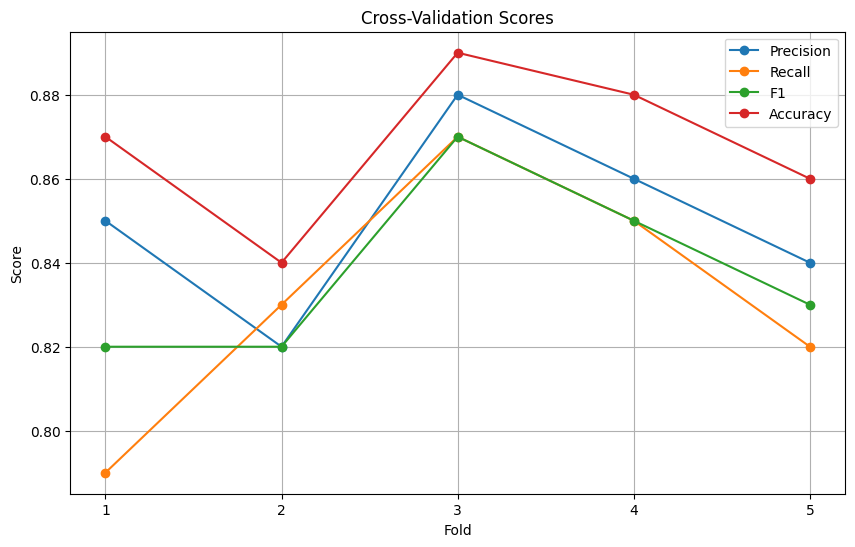

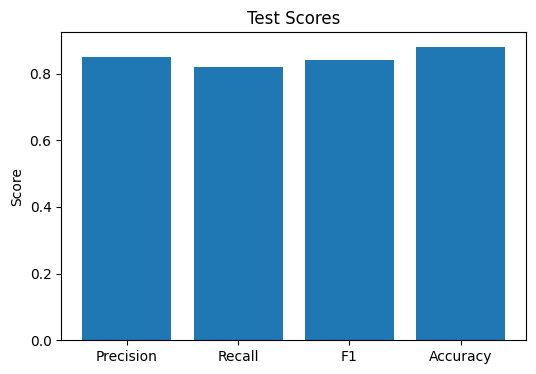

In [187]:
import matplotlib.pyplot as plt

# Cross-validation scores
cv_precision = [0.85, 0.82, 0.88, 0.86, 0.84]
cv_recall = [0.79, 0.83, 0.87, 0.85, 0.82]
cv_f1 = [0.82, 0.82, 0.87, 0.85, 0.83]
cv_accuracy = [0.87, 0.84, 0.89, 0.88, 0.86]

# Test scores
test_precision = 0.85
test_recall = 0.82
test_f1 = 0.84
test_accuracy = 0.88

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_precision, marker='o', label='Precision')
plt.plot(range(1, 6), cv_recall, marker='o', label='Recall')
plt.plot(range(1, 6), cv_f1, marker='o', label='F1')
plt.plot(range(1, 6), cv_accuracy, marker='o', label='Accuracy')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cross-Validation Scores')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()

# Plotting the test scores
plt.figure(figsize=(6, 4))
scores = [test_precision, test_recall, test_f1, test_accuracy]
labels = ['Precision', 'Recall', 'F1', 'Accuracy']
plt.bar(labels, scores)
plt.ylabel('Score')
plt.title('Test Scores')
plt.show()


In [223]:
def RocketForVitalsMM(vitals_windowed,filtered_icustay_ids):
    vitals_windowed = vitals_windowed[vitals_windowed['icustay_id'].isin(filtered_icustay_ids)]
    vitals_windowed['charttime'] = pd.to_datetime(vitals_windowed['charttime'])
    feature_columns = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity', 'appetite_median']
    
    grouped_data = vitals_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_columns + ['ckd']]
    
    X = []
    y = []
    for _, group in grouped_data:
        group_values = group[feature_columns].values.T
        num_timestamps = group_values.shape[1]
        
        if num_timestamps < WINDOW_LENGTH:
            padded_values = np.pad(group_values, ((0, 0), (0, WINDOW_LENGTH - num_timestamps)), 'constant', constant_values=0)
        elif num_timestamps > WINDOW_LENGTH:        
            padded_values = group_values[:, :WINDOW_LENGTH]
        else:        
            padded_values = group_values
        
        X.append(padded_values)
        y.append(group['ckd'].iloc[0])
    
    X = np.array(X)
    y = np.array(y)
    
    n_samples, n_features, n_channels = X.shape
    X_2d = X.reshape((n_samples, n_features*n_channels))

    rus = SMOTE(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_2d, y)

    X_resampled = X_resampled.reshape((X_resampled.shape[0], n_features, n_channels))    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("X_train shape: ",X_train.shape,"\ny_train shape: ",y_train.shape)
    
    rocket = Rocket(num_kernels=100, random_state=42)
    rocket.fit(X_train)
    X_train_transformed = rocket.transform(X_train)
    X_test_transformed = rocket.transform(X_test)
    
    clf = LogisticRegression()
    cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    
    X_test_transformed['y_pred'] = y_pred
    X_test_transformed['y_test'] = y_test
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    
    return X_test_transformed

In [224]:
def RocketForLabsMM(filtered_labs_windowed,filtered_icustay_ids,stratified_icuid_train,stratified_icuid_test):
    filtered_labs_windowed = filtered_labs_windowed[filtered_labs_windowed['icustay_id'].isin(filtered_icustay_ids)]
    filtered_labs_windowed['charttime'] = pd.to_datetime(filtered_labs_windowed['charttime'])    
    feature_columns= ['aniongap', 'albumin', 'bands',
           'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
           'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
           'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']
    grouped_data_labs = filtered_labs_windowed.sort_values(['icustay_id', 'charttime']).groupby('icustay_id')[feature_columns + ['ckd']]


    train_size = int(0.8 * len(icustay_ids))
    train_ids=stratified_icuid_train
    test_ids=stratified_icuid_test
    X_train_labs = []
    X_test_labs = []
    y_train_labs = []
    y_test_labs = []
     
    X = []
    y = []
    for _, group in grouped_data_labs:
        group_values = group[feature_labs].values.T
        X.append(group_values)
        y.append(group['ckd'].iloc[0])

    X = np.array(X)
    y = np.array(y) 
    
    n_samples, n_features, n_channels = X.shape
    X_2d = X.reshape((n_samples, n_features*n_channels))
    rusLab = SMOTE(random_state=42)
    
    X_resampled, y_resampled = rusLab.fit_resample(X_2d, y)
    X_resampled = X_resampled.reshape((X_resampled.shape[0], n_features, n_channels))   
    
    for icustay_id, group in grouped_data_labs:
        if icustay_id in train_ids:
            lab_values = group[feature_labs].values.T
            X_train_labs.append(lab_values)
            y_train_labs.append(group['ckd'].iloc[0])
        elif icustay_id in test_ids:
            lab_values = group[feature_labs].values.T
            X_test_labs.append(lab_values)
            y_test_labs.append(group['ckd'].iloc[0])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
    
    
    print("X_train shape: ",X_train.shape,"\ny_train shape: ",y_train.shape)
    rocket = Rocket(num_kernels=100)
    rocket.fit(X_train)
    X_train_transformed = rocket.transform(X_train)
    X_test_transformed = rocket.transform(X_test)
    
    clf = LogisticRegression()
    cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    
    X_test_transformed['y_pred'] = y_pred
    X_test_transformed['y_test'] = y_test
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    
    return X_test_transformed

In [232]:
def RFforDemographicsMM(train_ids,test_ids,merged_table):  
    train_data = merged_table.loc[merged_table['icustay_id'].isin(train_ids)]
    test_data = merged_table.loc[merged_table['icustay_id'].isin(test_ids)]
    
    test_ids_not_in_table = set(test_ids) - set(merged_table['icustay_id'])
    print(test_ids_not_in_table)
    
    X_train_static=train_data[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
    y_train_static=train_data['ckd']
    X_train_static=pd.get_dummies(X_train_static)
    
    X_test_static=test_data[['gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group']]
    y_test_static=test_data['ckd']
    X_test_static=pd.get_dummies(X_test_static)
        
    rus = RandomOverSampler(random_state=42)
    X_resampled_static, y_resampled_static = rus.fit_resample(X_train_static, y_train_static)
    #X_resampled_vitals = X_resampled_vitals.reshape((X_resampled_vitals.shape[0], n_features, n_channels))
    X_train_static = X_resampled_static
    y_train_static = y_resampled_static
    
    print("X_train_static shape: ",X_train_static.shape,"\n y_train_static shape: ",y_train_static.shape)
    
    rf_same.fit(X_train_static,y_train_static)
    
    y_pred = rf_same.predict(X_test_static)
    X_test_static['y_pred'] = y_pred
    X_test_static['y_test'] = y_test_static
    
    precision = precision_score(y_test_static, y_pred)
    recall = recall_score(y_test_static, y_pred)
    f1 = f1_score(y_test_static, y_pred)
    accuracy = accuracy_score(y_test_static, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    
    return X_test_static

In [226]:
X_dem_mm = RFforDemographicsMM(train_ids,test_ids,merged_table)

set()
X_train_static shape:  (4302, 20) 
 y_train_static shape:  (4302,)
Precision: 0.1065989847715736
Recall: 0.5384615384615384
F1 Score: 0.17796610169491525
Accuracy: 0.7433862433862434


In [227]:
X_lab_mm = RocketForLabsMM(filtered_labs_windowed,filtered_icustay_ids)

X_train shape:  (4611, 11, 13) 
y_train shape:  (4611,)


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.78764897 0.77006508 0.77223427 0.79934924 0.77874187]
Mean cross-validation score: 0.7816078852558032
Precision: 0.7604327666151468
Recall: 0.841025641025641
F1 Score: 0.7987012987012988
Accuracy: 0.784908933217693


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [228]:
X_vit_mm = RocketForVitalsMM(vitals_windowed,filtered_icustay_ids)

C:\Users\navim\AppData\Local\Temp\ipykernel_25608\3131791215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals_windowed['charttime'] = pd.to_datetime(vitals_windowed['charttime'])


X_train shape:  (4611, 11, 96) 
y_train shape:  (4611,)


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.77356446 0.77006508 0.78416486 0.7516269  0.7527115 ]
Mean cross-validation score: 0.7664265586846626
Precision: 0.7297687861271677
Recall: 0.8473154362416108
F1 Score: 0.7841614906832299
Accuracy: 0.7588898525585429


In [234]:
merged_table.shape

(3024, 30)